In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from scipy.optimize import linprog 
from scipy.optimize import lsq_linear
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
import re
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
import pickle
time_1 = datetime.datetime.now()
warnings.filterwarnings('ignore')
plt.rcParams["font.family"]='Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.figsize'] = (18,8)   
plt.rcParams['figure.dpi'] = 300.0  # 分辨率
plt.rcParams['savefig.dpi'] = 300.0  # 图片像素
harvest_red = '#a50000'
harvest_gray = '#b5b6b6'

warnings.filterwarnings('ignore')
######################################################################
os.chdir('./data')
######################################################################


方式方法主要参考：华泰金工研报\
《风格稳定的绩优股票基金筛选策略基于风格稳定性与业绩持续性的相关关系规律》\
要求是测定 基金的 价值/成长和大/小盘风格 \
因此我们采用研报中的方法 对结果进行回归 \
看该研报中的结果 要求参数和为1；看之后的结果，应该各参数的值也需要控制在-1到1的范围中\

可以转化为二次优化问题进行处理。对因子暴露程度进行处理\
具体过程如下：这种方法将确保因子的系数在-1到1之间且和为1

In [2]:
index_values = pd.read_excel('data.xlsx',sheet_name = '巨潮风格指数')
index_values = index_values.drop(0,axis = 0)
index_values['日期'] = pd.to_datetime(index_values['日期'])
index_values = index_values.set_index('日期')
index_values = index_values.astype(float)
fund_values = pd.read_excel('data.xlsx',sheet_name = '基金净值')
fund_values = fund_values.drop(0,axis = 0)
fund_values['日期'] = pd.to_datetime(fund_values['日期'])
fund_values = fund_values.set_index('日期')
fund_values = fund_values.astype(float)
index_values_for_analytics = index_values[['中债总财富指数','大盘成长', '大盘价值', '小盘成长', '小盘价值']].copy()
index_values_for_analytics = index_values_for_analytics.transform(np.log).diff(1)
fund_values = fund_values.transform(np.log).diff(1)

In [3]:
output_total = pd.DataFrame()
for i in ['南方中小盘成长', '安信价值精选', '嘉实研究阿尔法']:
    fund_for_analytics = pd.merge(fund_values[[i]].dropna(),
                              index_values_for_analytics,
                              left_index = True,
                              right_index = True,
                              how = 'left')
    x = np.full(5,0.2).reshape(5,1)
    bounds = Bounds(np.full(5,-1),np.full(5,1))
    conn = LinearConstraint(np.full(5,1),1, 1)
    def f(x):
        a = np.matmul(fund_for_analytics[index_values_for_analytics.columns].values , x)-fund_for_analytics[i].values
        return np.matmul(a.reshape(1,len(fund_for_analytics)),a.reshape(len(fund_for_analytics),1))[0][0]
    result = minimize(
        f, x, 
        bounds=bounds,
        constraints=conn)
    y = fund_for_analytics[i]
    x = fund_for_analytics[index_values_for_analytics.columns] 
    est=sm.OLS(y,x)
    model=est.fit()
    
    output = pd.DataFrame(model.pvalues.round(3)).rename(columns = {0:'p-values'})
    output['coef'] = result.x.round(3)
    output=output[['coef','p-values']].rename(columns =
                                       {
                                           'coef':i+'coef',
                                           'p-values':i+'p-values'
                                       })

    output_total = output_total.append(output.T)
    
    
output_total = output_total.T
output_total.to_excel("基金价值成长和大小盘风格-线性规划.xlsx")

In [4]:
name_list_for_sharpee = []
for i in ['南方中小盘成长', '安信价值精选', '嘉实研究阿尔法']:
    fund_for_analytics = pd.merge(fund_values[[i]].dropna(),
                              index_values_for_analytics,
                              left_index = True,
                              right_index = True,
                              how = 'left')
    trail = pd.DataFrame(fund_for_analytics.resample('2M'))
    def reg1(input_1):
        x = np.full(5,0.2).reshape(5,1)
        bounds = Bounds(np.full(5,-1),np.full(5,1))
        conn = LinearConstraint(np.full(5,1),1, 1)
        def f(x):
            a = np.matmul(input_1[['中债总财富指数','大盘成长', '大盘价值', '小盘成长', '小盘价值']].values , x)-input_1[i].values
            return np.matmul(a.reshape(1,len(input_1)),a.reshape(len(input_1),1))[0][0]
        result = minimize(
            f, x, 
            bounds=bounds,
            constraints=conn)
        return pd.Series(result.x.round(3))

    trail = trail[1].transform(reg1).set_index(trail[0])
    trail.columns = ['中债总财富指数','大盘成长', '大盘价值', '小盘成长', '小盘价值']
    trail.to_excel(i+'roll_result_on_sp_linear_programming.xlsx')
    name_list_for_sharpee.append(i+'roll_result_on_sp_linear_programming.xlsx')

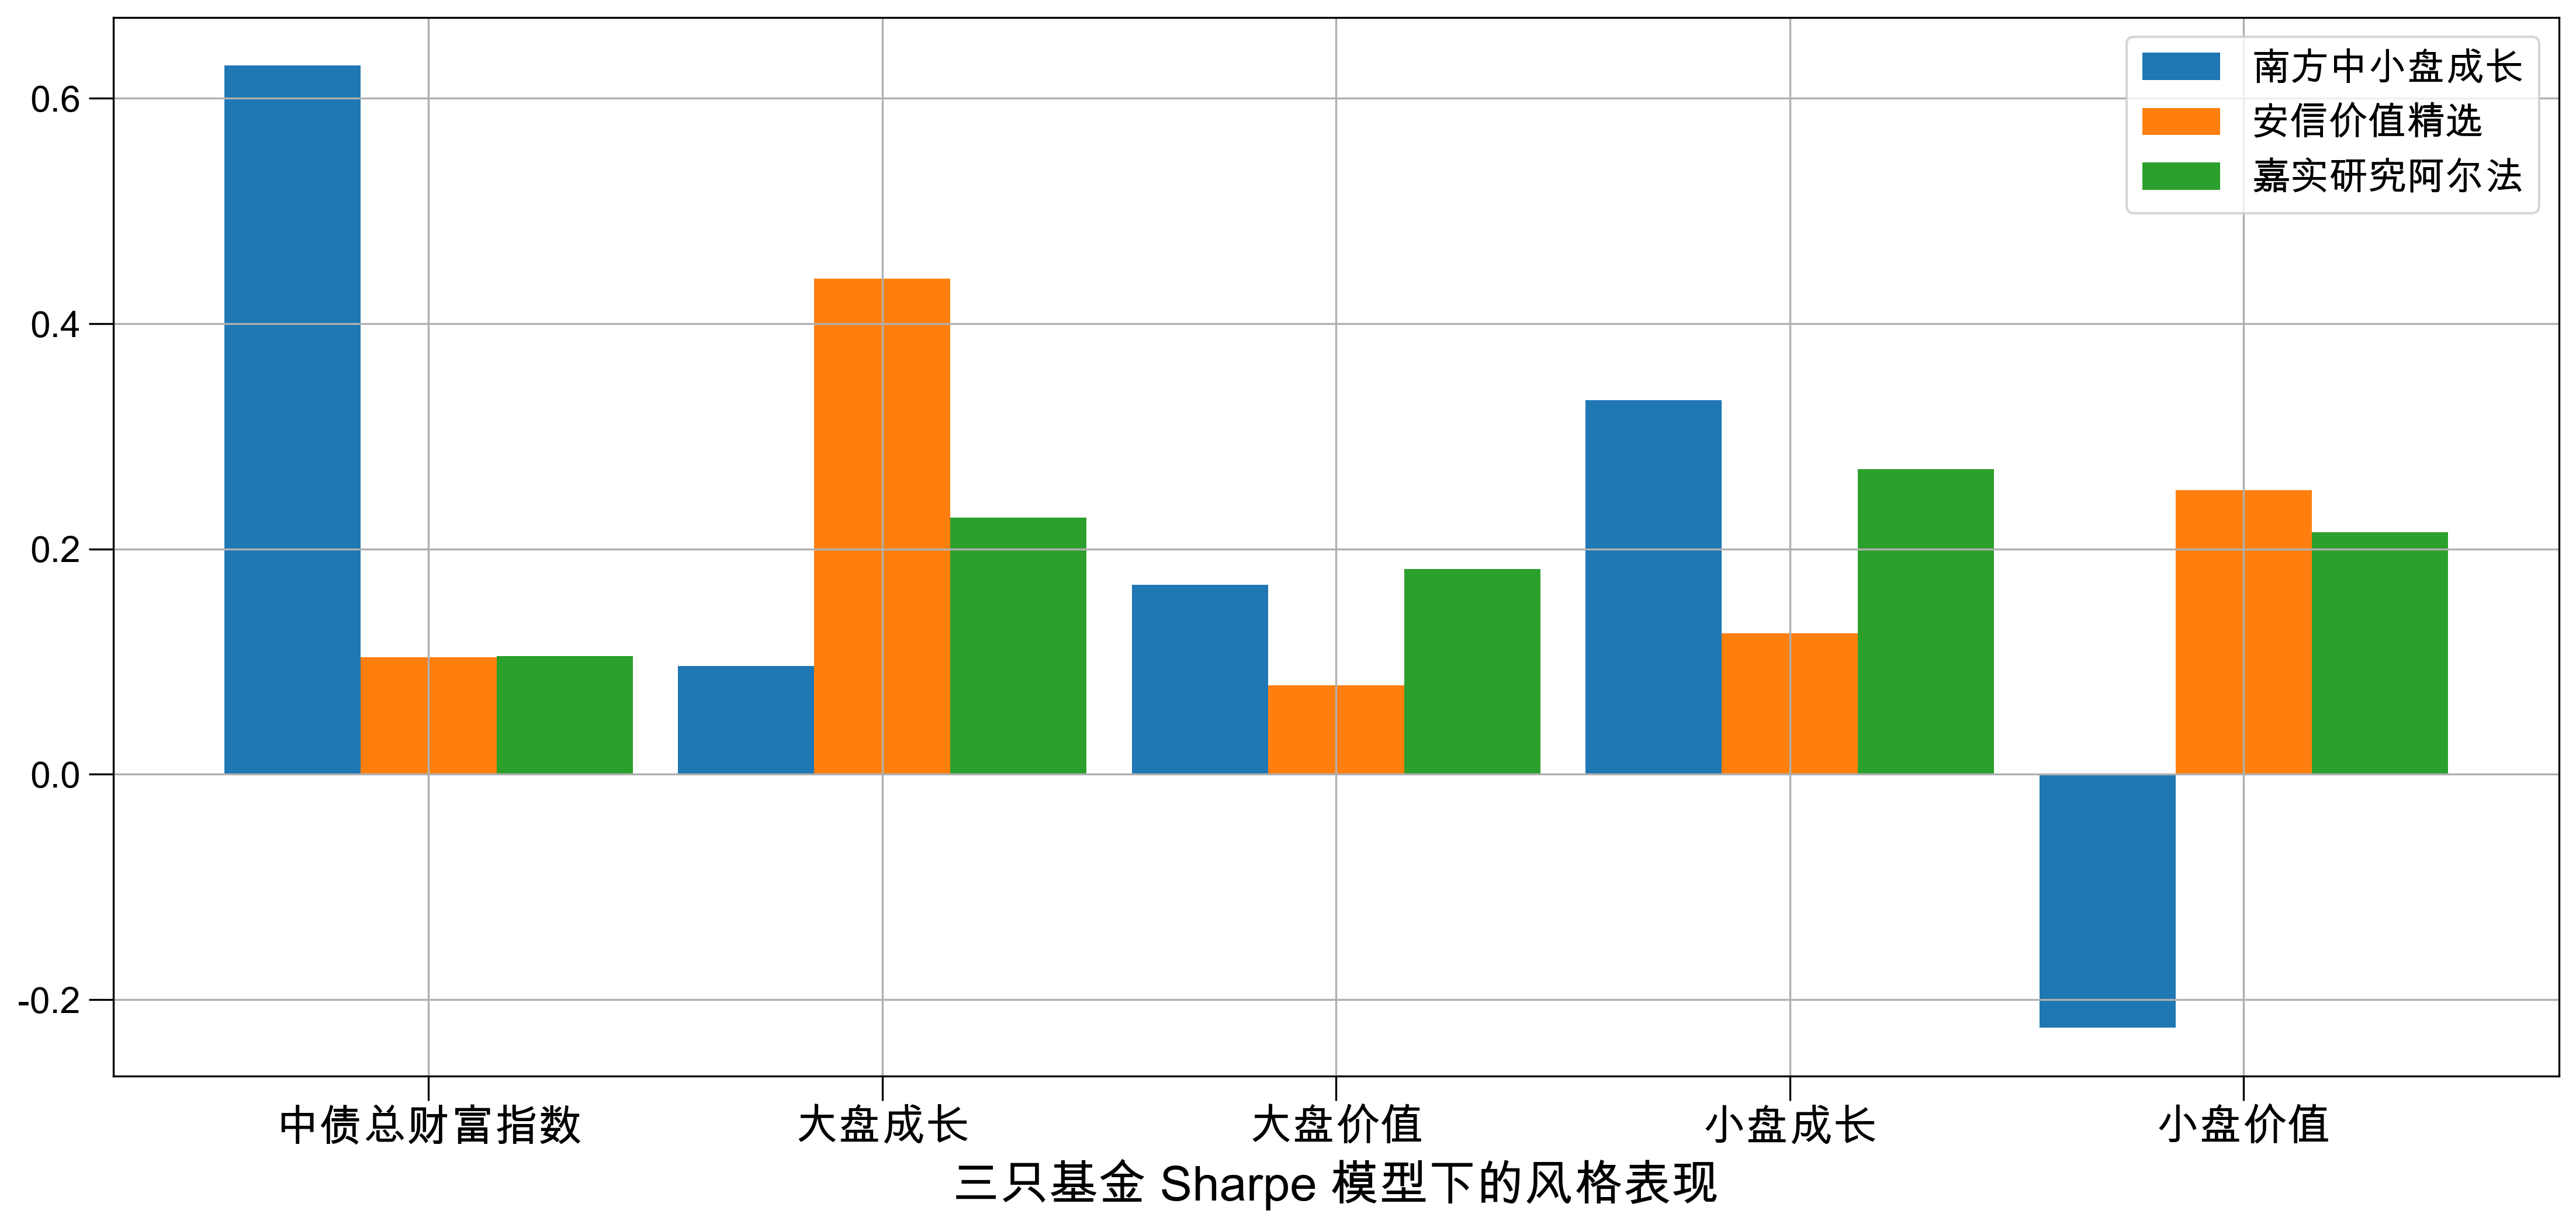

In [5]:
data_for_draw = output_total.reset_index()
plt.bar(data_for_draw.index,data_for_draw['南方中小盘成长coef'],
        lw=0.5,width=0.3,label ='南方中小盘成长' )
plt.bar(data_for_draw.index+0.3,data_for_draw['安信价值精选coef'],
        lw=0.5,width=0.3,label ='安信价值精选' )
plt.bar(data_for_draw.index+0.6,data_for_draw['嘉实研究阿尔法coef'],
        lw=0.5,width=0.3,label = '嘉实研究阿尔法')

plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)

plt.legend(fontsize=16)
plt.grid()
plt.xlabel('三只基金 Sharpe 模型下的风格表现',fontsize=20)

plt.savefig('三只基金 Sharpe 模型下的风格表现.jpg')



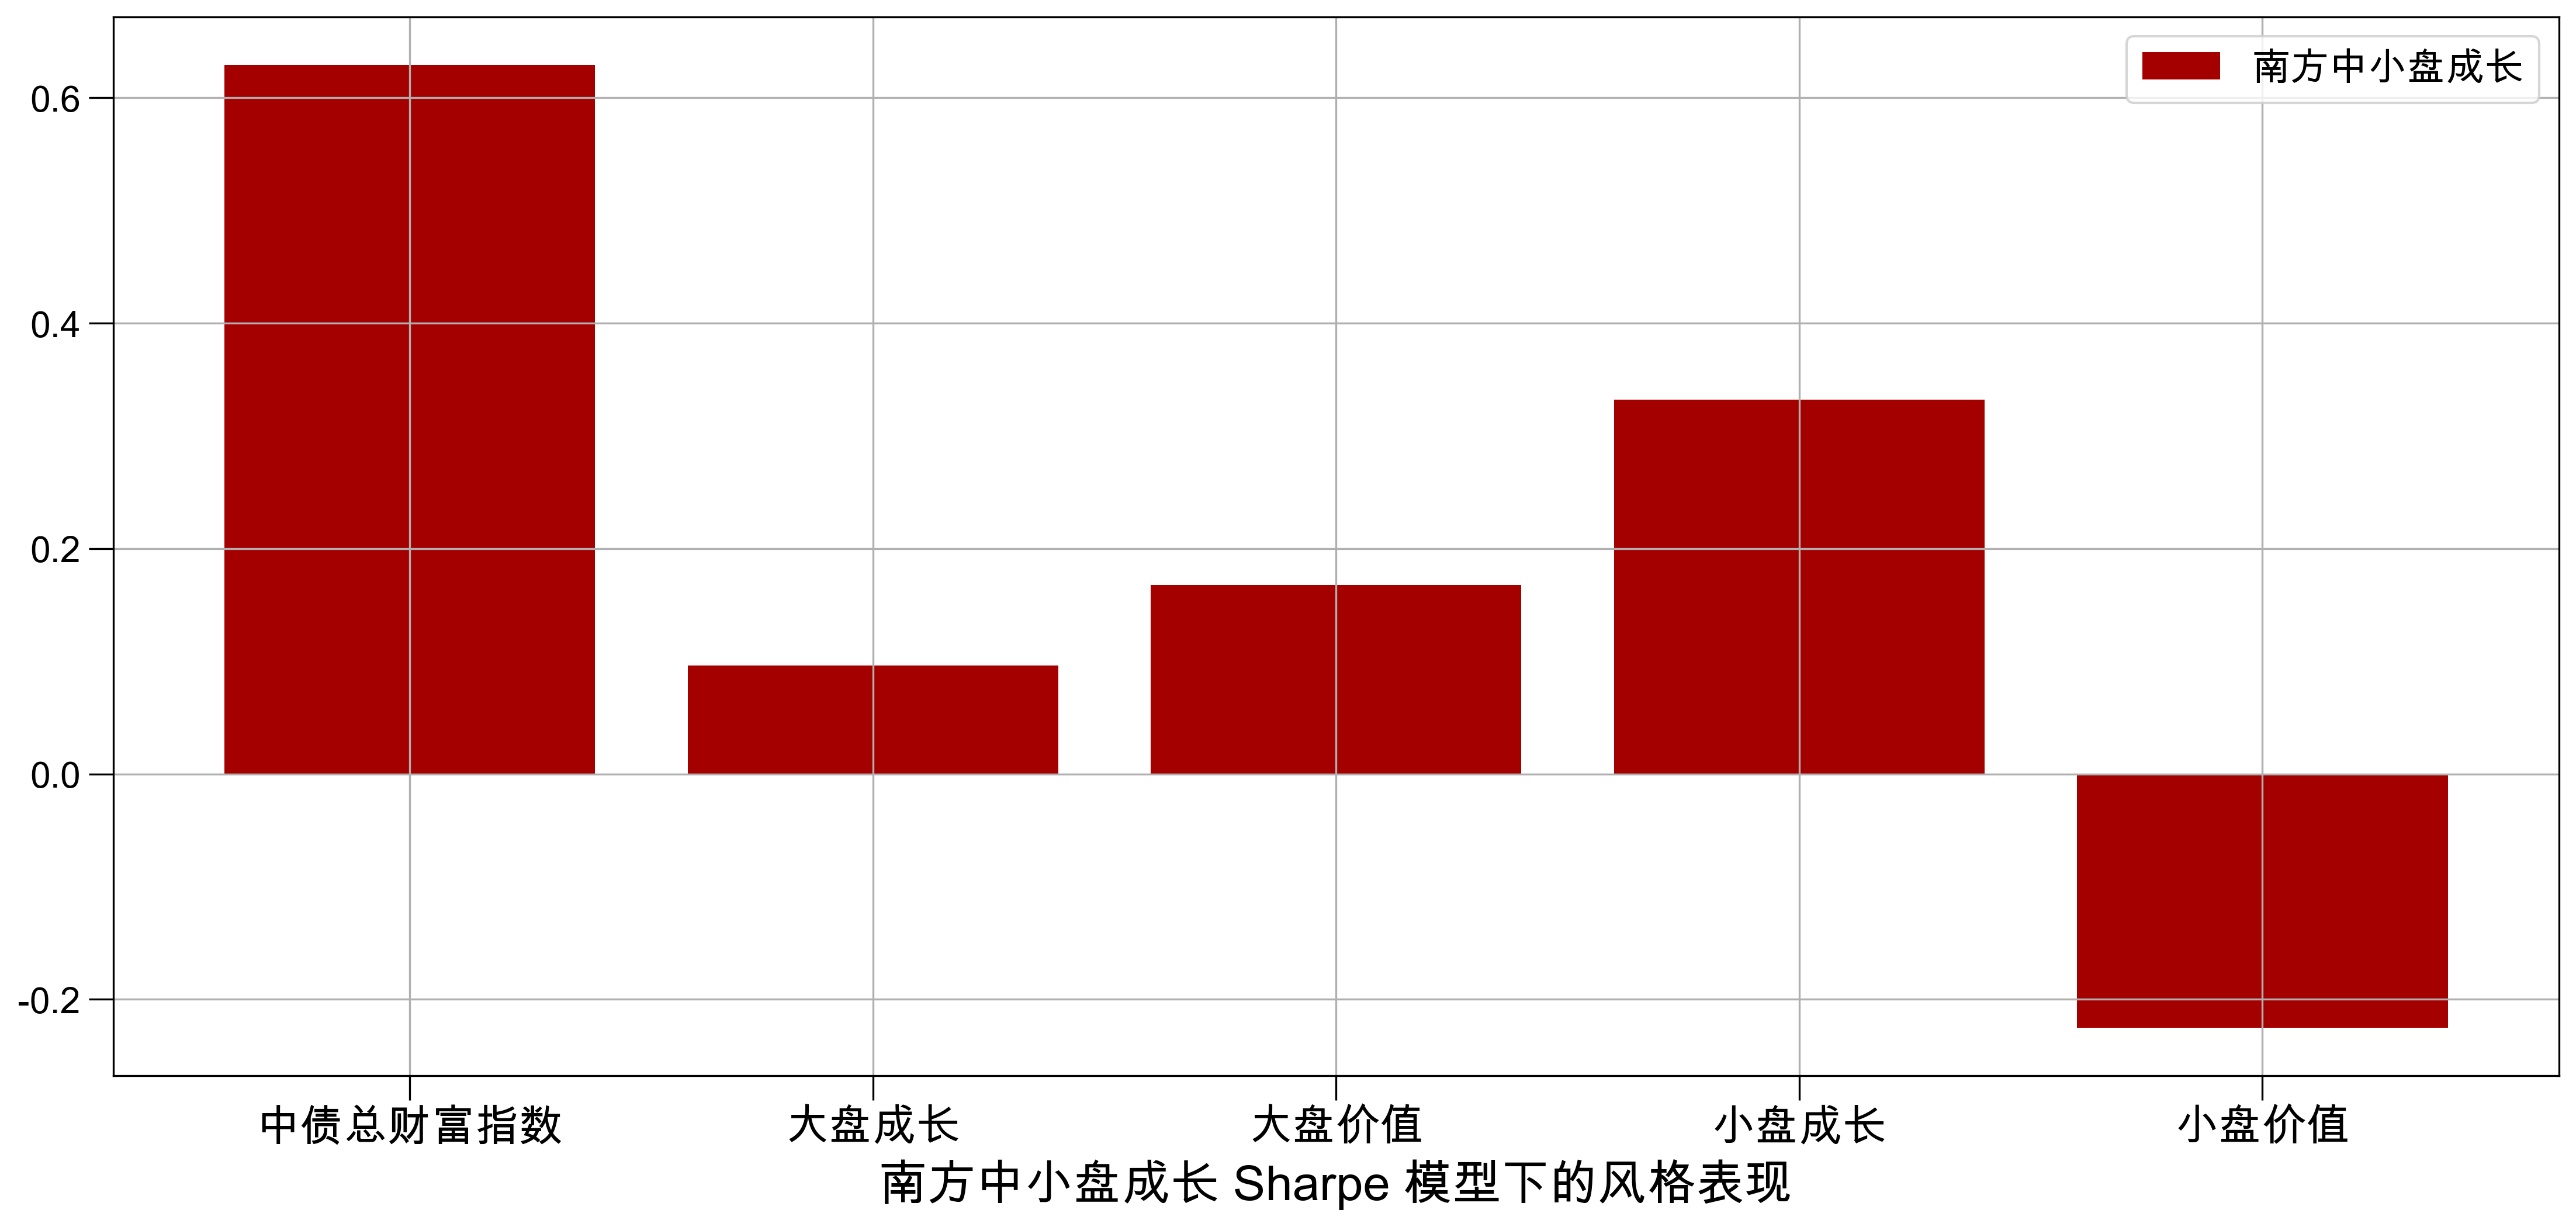

In [6]:
plt.bar(data_for_draw.index,data_for_draw['南方中小盘成长coef'],label ='南方中小盘成长',color = harvest_red )
plt.xticks(data_for_draw.index, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('南方中小盘成长 Sharpe 模型下的风格表现',fontsize=20)
plt.savefig('南方中小盘成长 Sharpe 模型下的风格表现.jpg')

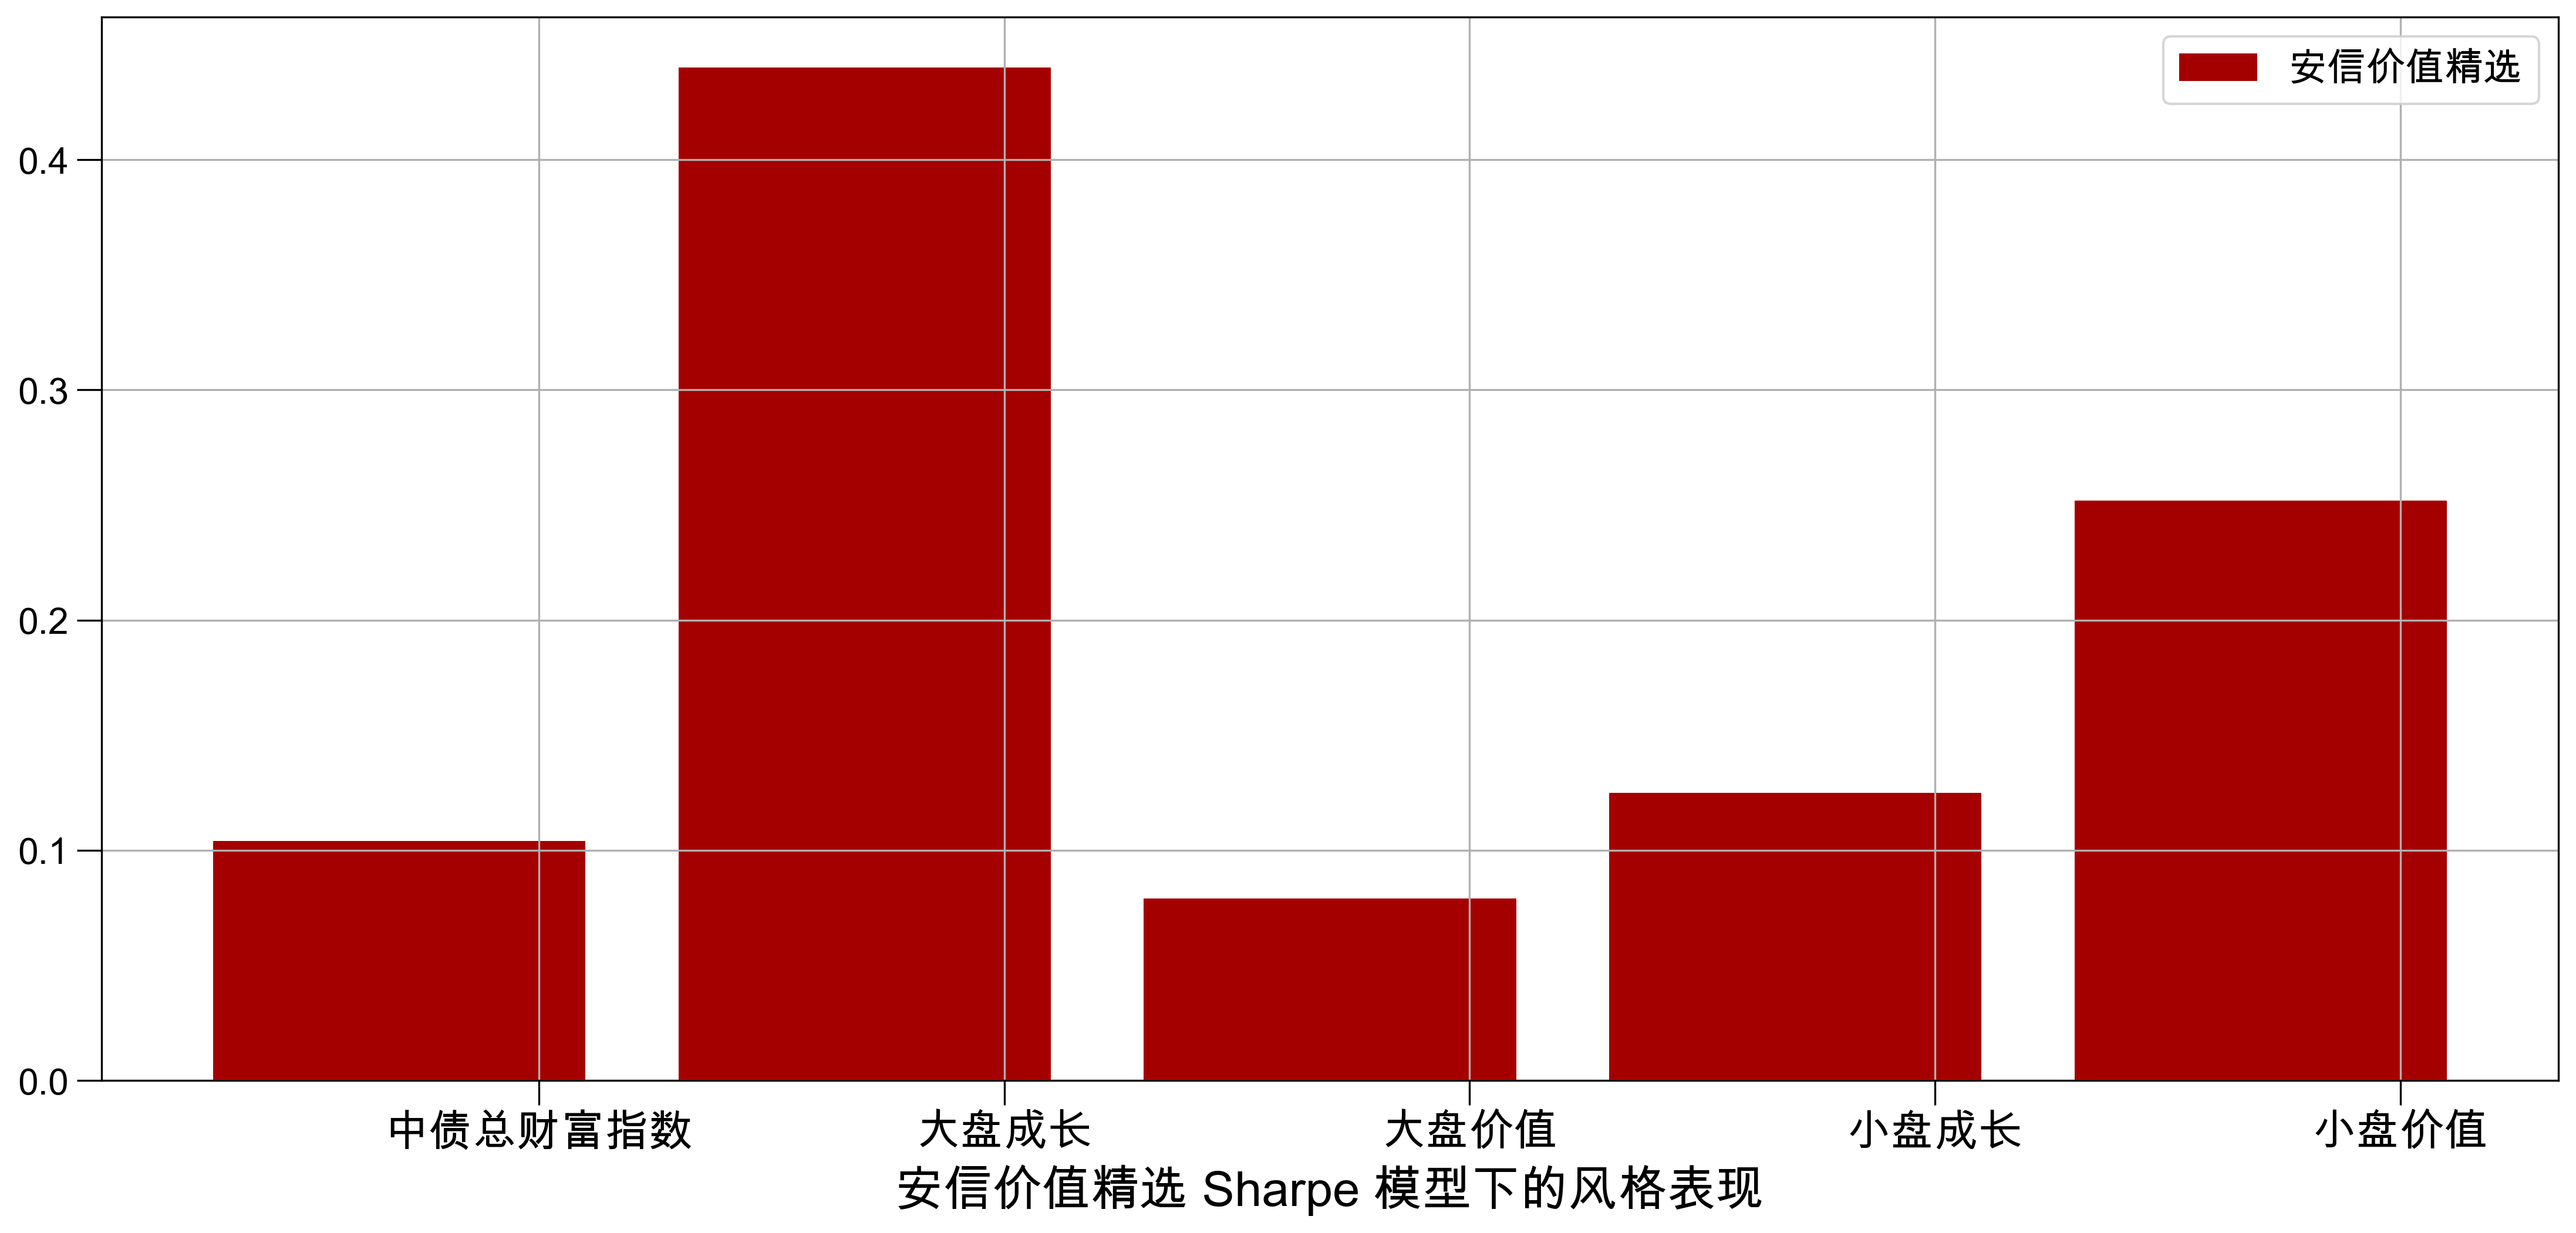

In [7]:
plt.bar(data_for_draw.index,data_for_draw['安信价值精选coef'],label ='安信价值精选' ,color = harvest_red)
plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('安信价值精选 Sharpe 模型下的风格表现',fontsize=20)
plt.savefig('安信价值精选 Sharpe 模型下的风格表现.jpg')

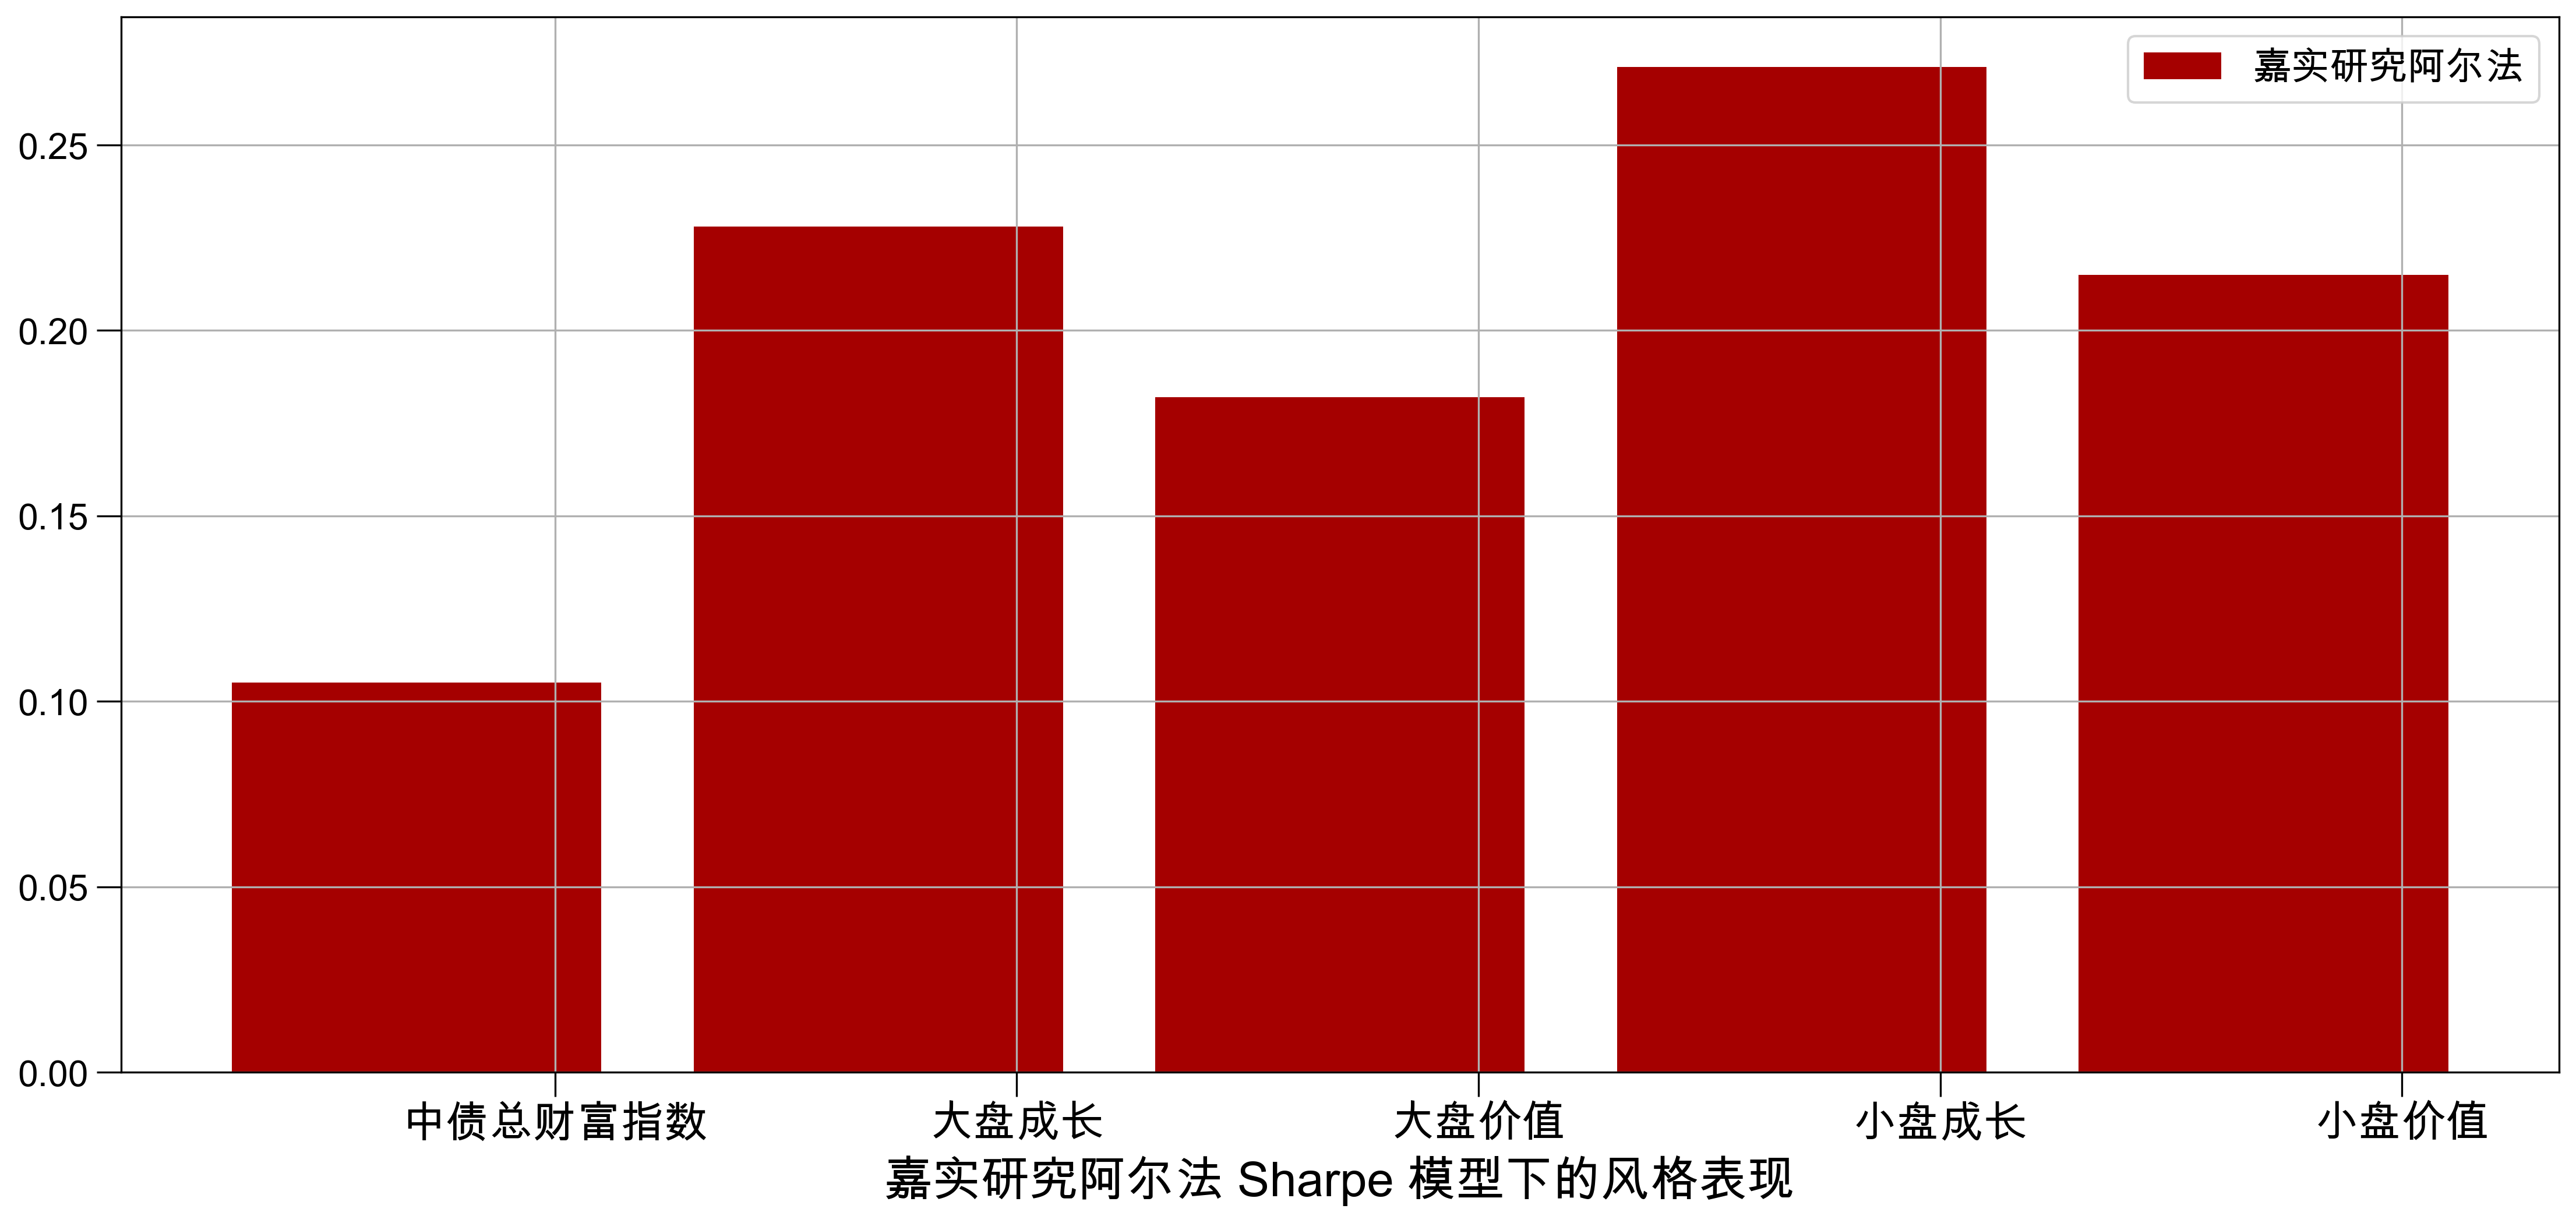

In [8]:
plt.bar(data_for_draw.index,data_for_draw['嘉实研究阿尔法coef'],label = '嘉实研究阿尔法',color = harvest_red)
plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('嘉实研究阿尔法 Sharpe 模型下的风格表现',fontsize=20)
plt.savefig('嘉实研究阿尔法 Sharpe 模型下的风格表现.jpg')

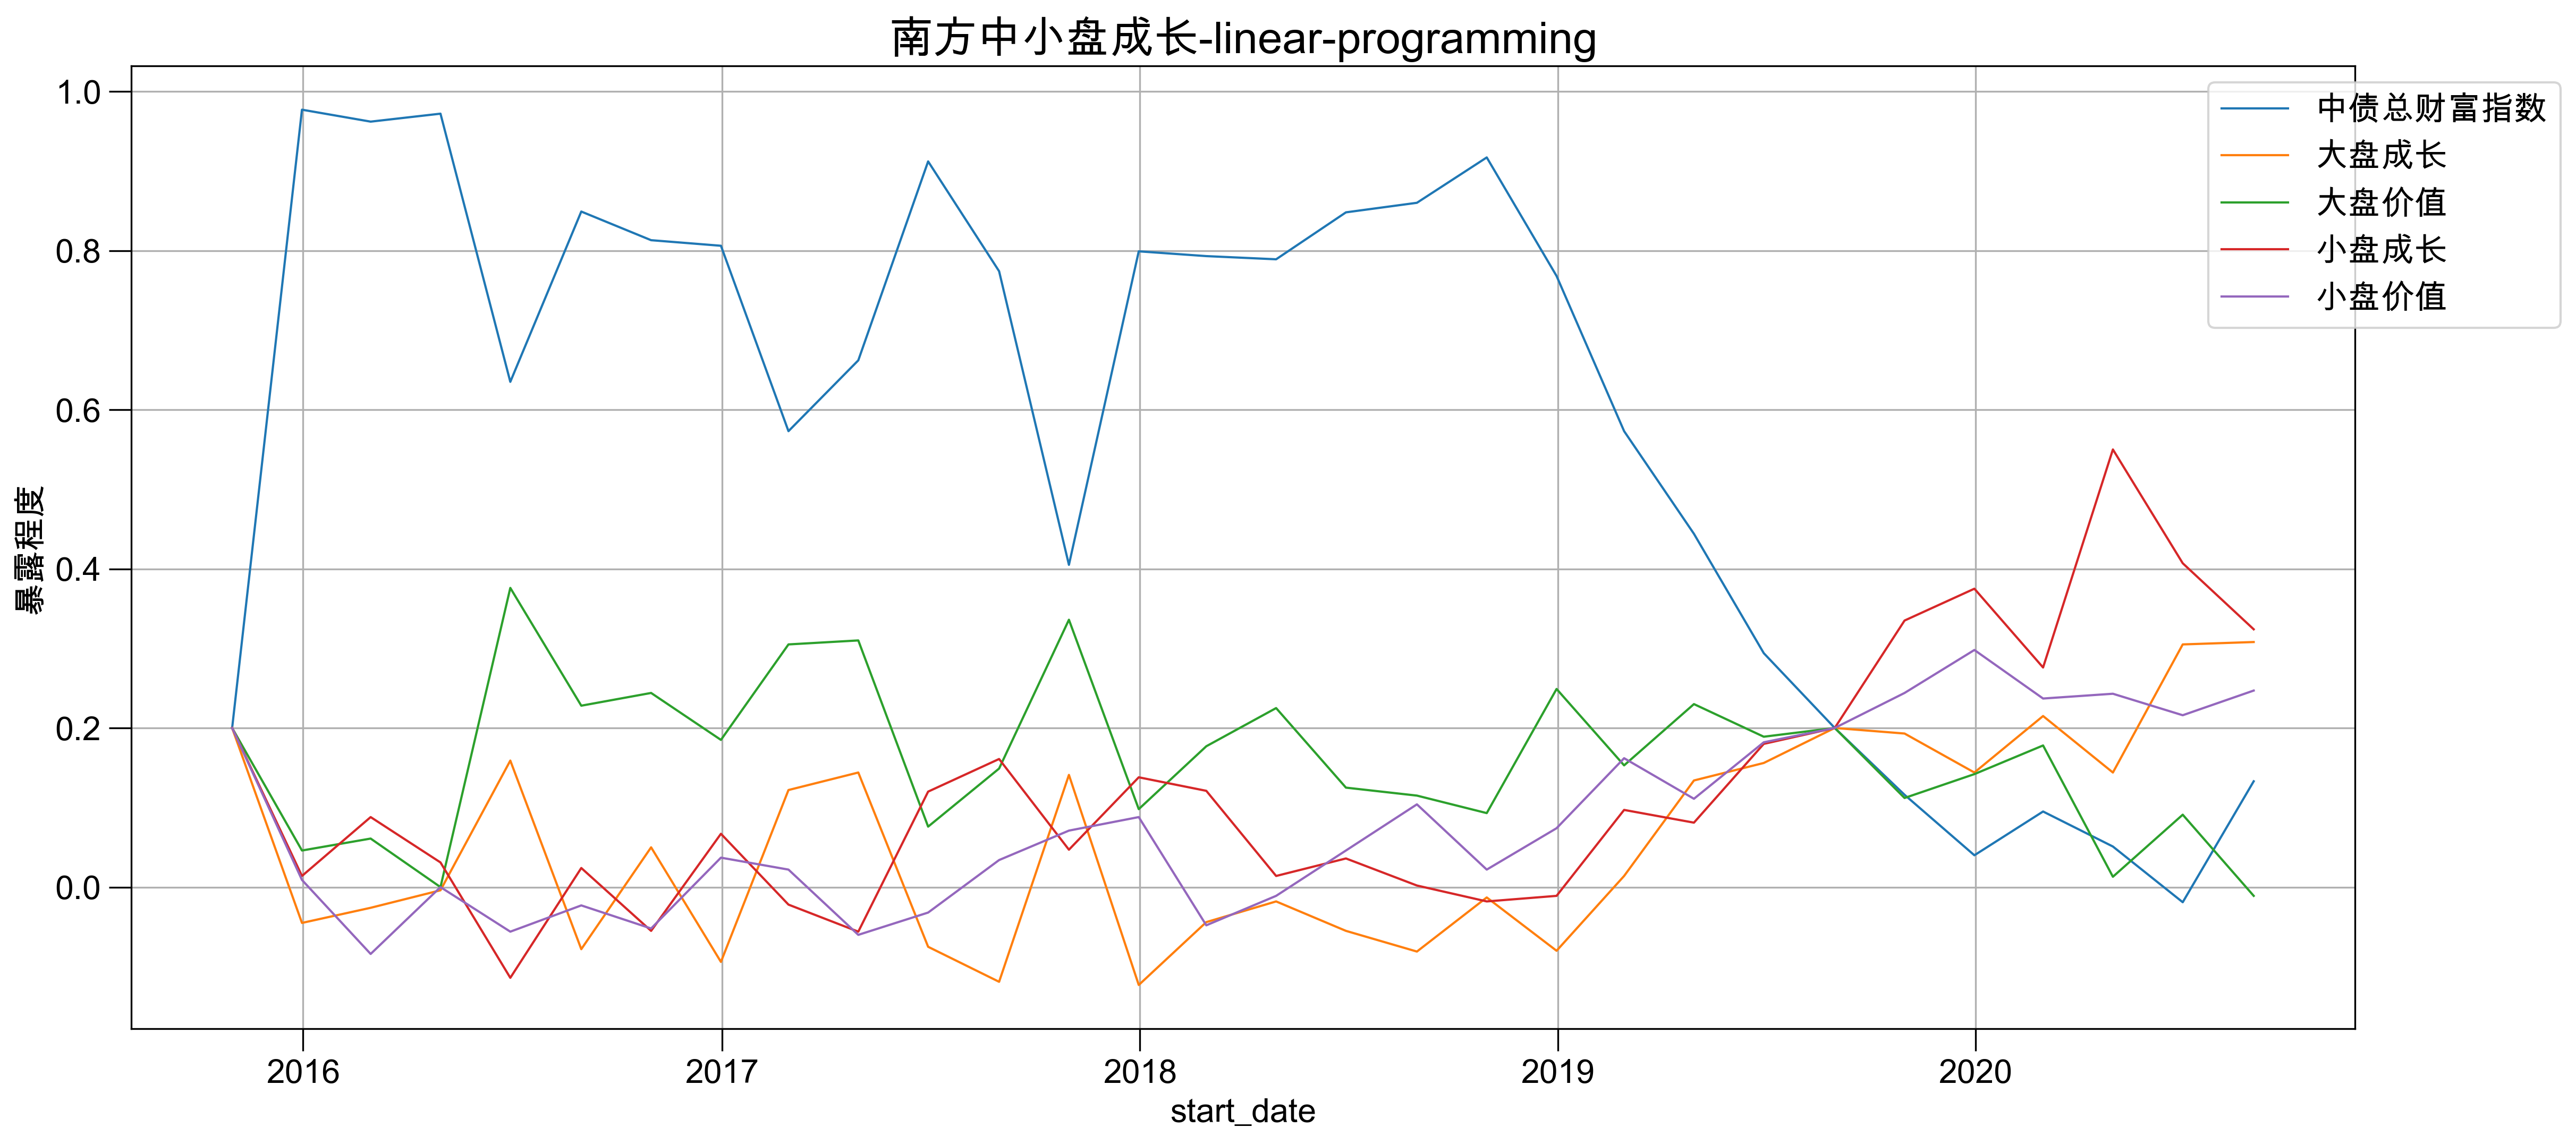

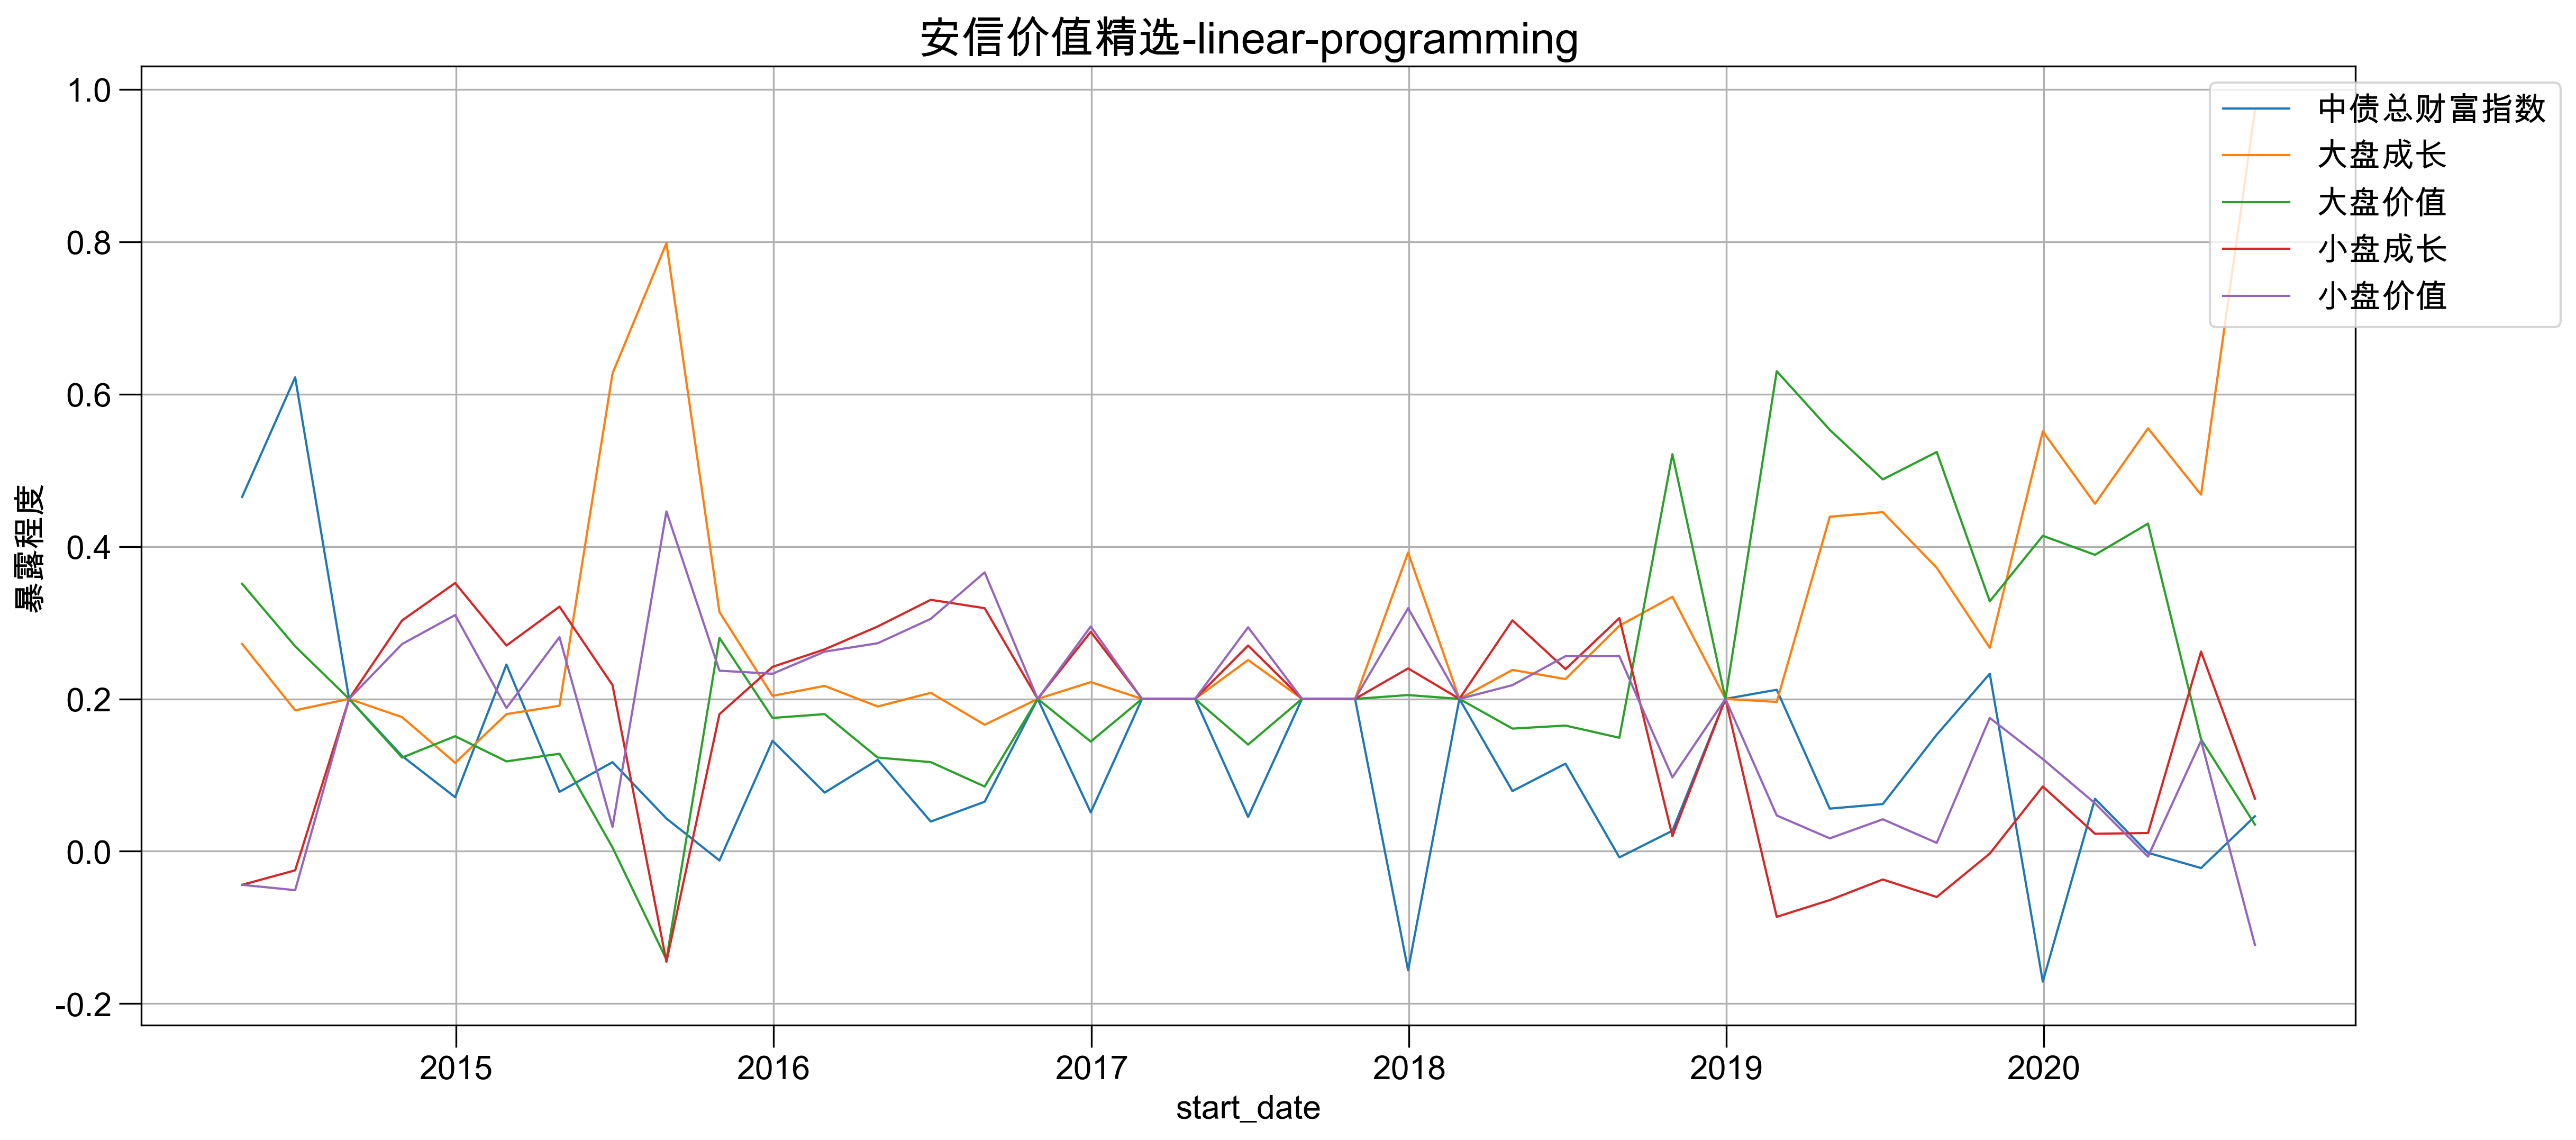

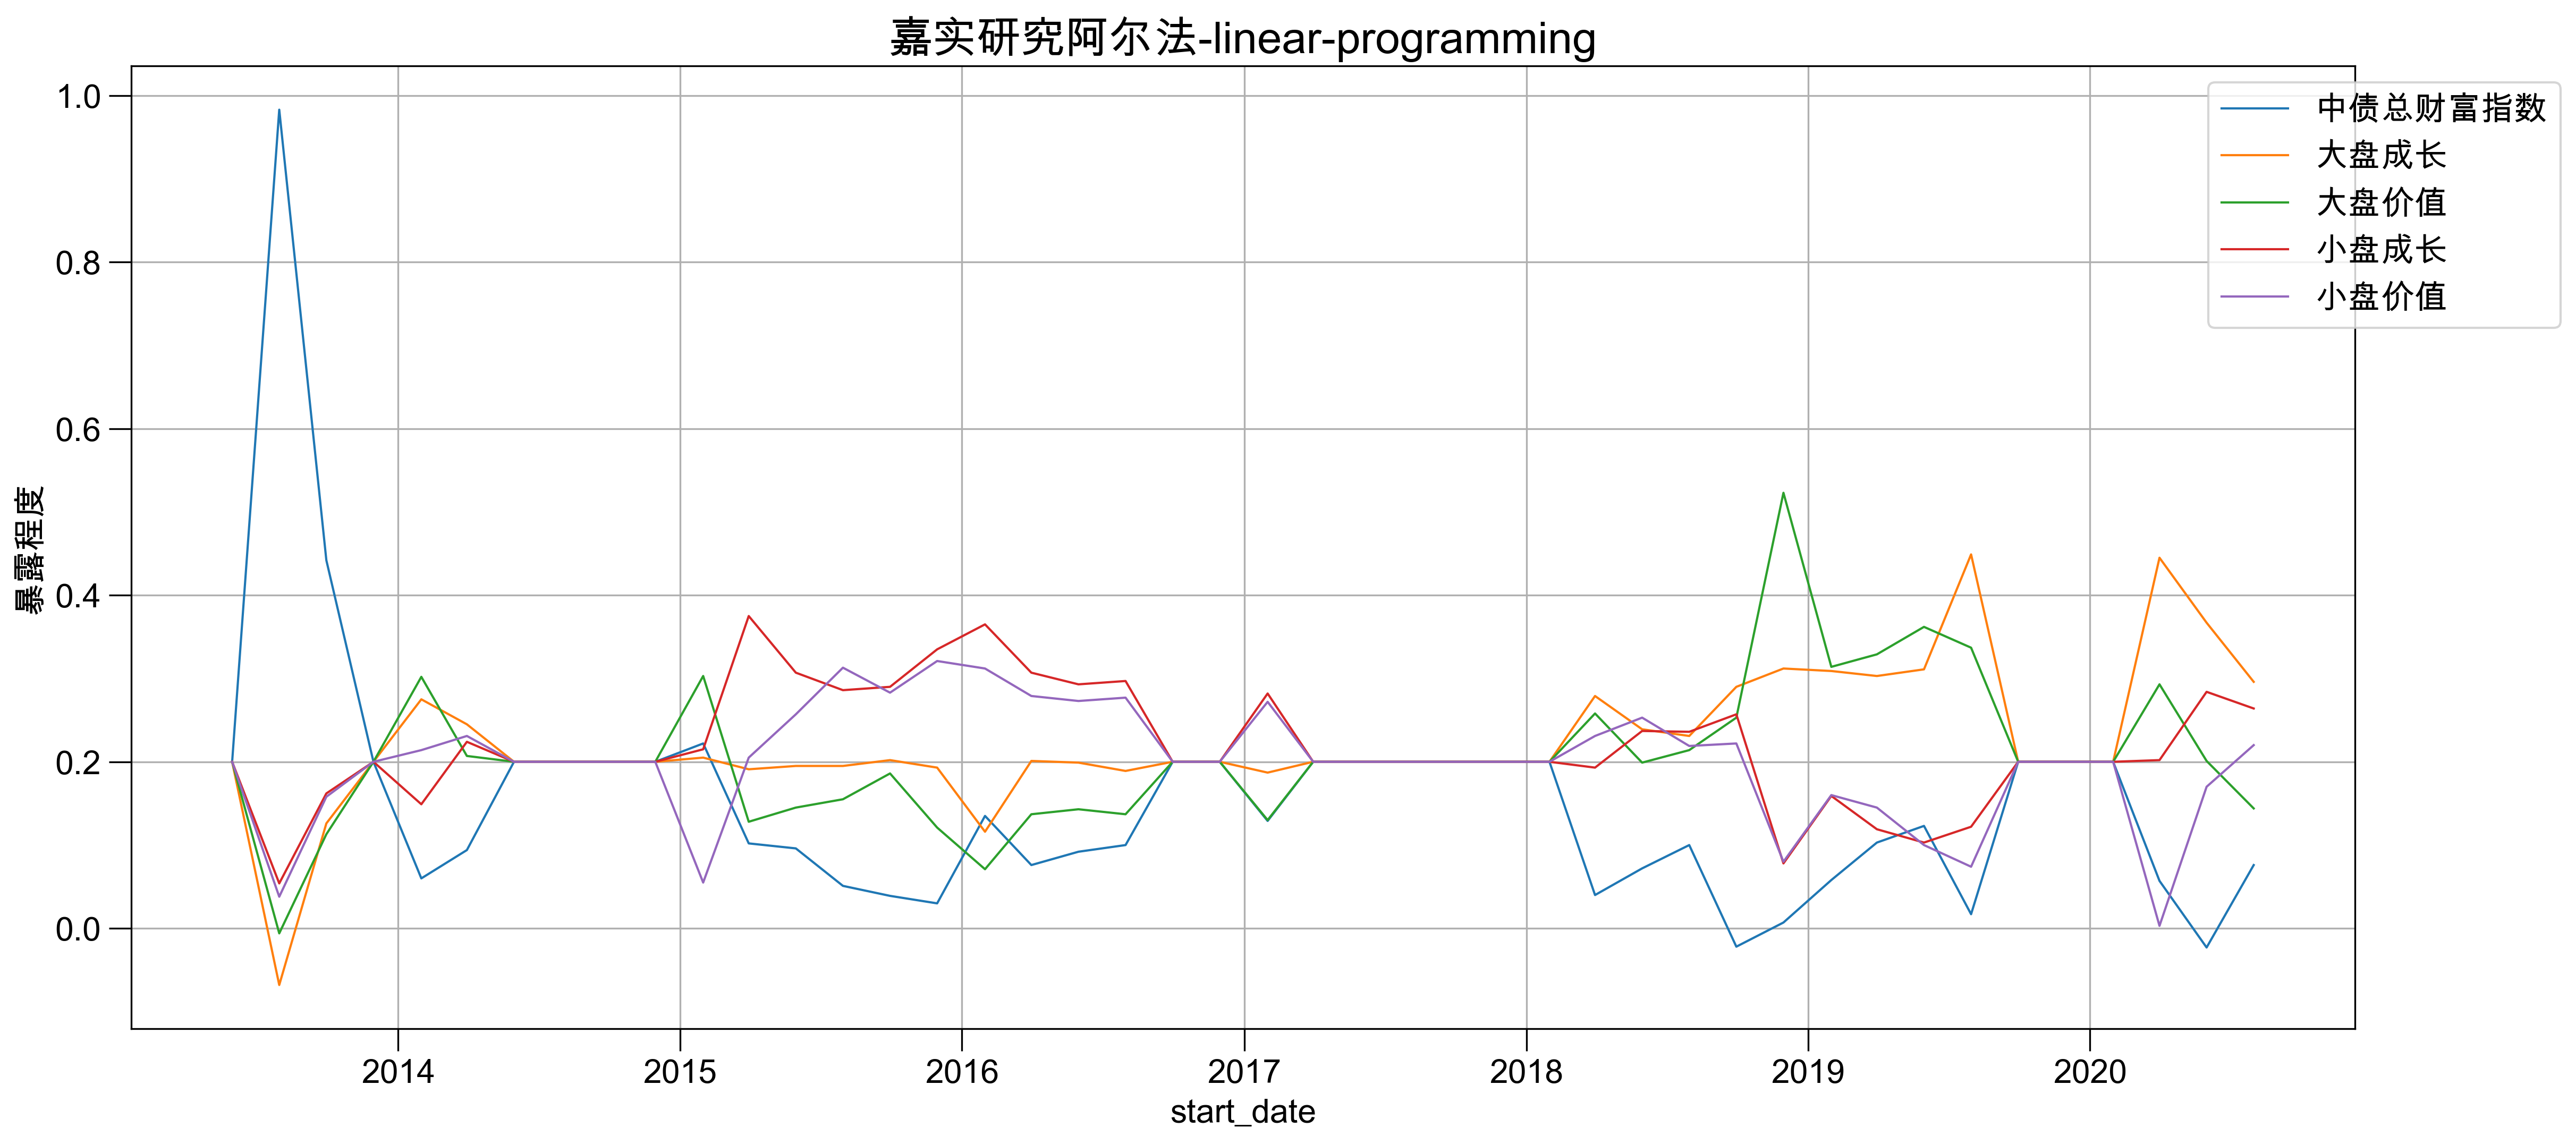

In [9]:
for j in range(len(name_list_for_sharpee)):
    data_1_for_draw = pd.read_excel(name_list_for_sharpee[j])
    data_1_for_draw = data_1_for_draw.rename(columns ={'Unnamed: 0':'日期'}).set_index('日期')
    plt.figure(figsize=(18,8))
    for i in data_1_for_draw.columns:
        plt.plot(data_1_for_draw[i].index,data_1_for_draw[i].values,
                 linestyle='-',  linewidth=1,label = i)

    plt.grid()
    plt.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
    plt.xlabel('start_date')
    plt.ylabel('暴露程度')
    plt.title(name_list_for_sharpee[j].split('roll')[0]+'-linear-programming',fontsize=20)
    #plt.ylim(0,150)
    plt.savefig(name_list_for_sharpee[j].split('roll')[0]+'-linear-programming.jpg')

#### 以FAMA三因子（MKT SMB HML）来测算三只基金的风格，并列出回归的相关参数和显著性
MKT：(沪深 300 收益+中证 500 收 益)*0.4+中债收益*0.2\
SMB：巨潮小盘指数收益率-巨潮大盘指数收益率\
HML:巨潮价值指数收益率-巨潮成长指数收益率

In [10]:
index_values = pd.read_excel('【笔试】基于净值的基金评价.xlsx',sheet_name = '巨潮风格指数')
index_values = index_values.drop(0,axis = 0)
index_values['日期'] = pd.to_datetime(index_values['日期'])
index_values = index_values.set_index('日期')
index_values = index_values.astype(float)
csi500 = pd.read_csv('csi500.csv')
csi500['日期'] = pd.to_datetime(csi500['日期'])
csi500 = csi500.sort_values('日期')
csi500 = csi500.set_index('日期')
csi500['收盘']= csi500[['收盘']].astype(str)
csi500['收盘'] = csi500['收盘'].apply(lambda x:re.sub(',','',x)).astype(float).transform(np.log).diff(1)
index_values = pd.merge(index_values,
         csi500[['收盘']].rename(columns = {'收盘':'csi500'}),
         left_index = True,
         right_index = True,
         how = 'left')
hs300 = pd.read_csv('hs300.csv')
hs300['日期'] = pd.to_datetime(hs300['日期'])
hs300 = hs300.sort_values('日期')
hs300 = hs300.set_index('日期')
hs300['收盘']= hs300[['收盘']].astype(str)
hs300['收盘'] = hs300['收盘'].apply(lambda x:re.sub(',','',x)).astype(float).transform(np.log).diff(1)
index_values = pd.merge(index_values,
         hs300[['收盘']].rename(columns = {'收盘':'hs300'}),
         left_index = True,
         right_index = True,
         how = 'left')
index_values['中债'] = index_values['中债总财富指数'].transform(np.log).diff(1)
index_values['MKT'] = index_values['中债']*0.2+index_values['hs300']*0.4+ index_values['csi500']*0.4
index_values['SMB'] = index_values['巨潮小盘'].transform(np.log).diff(1)-index_values['巨潮大盘'].transform(np.log).diff(1)
index_values['HML'] = index_values['巨潮价值'].transform(np.log).diff(1)-index_values['巨潮成长'].transform(np.log).diff(1)

In [11]:
fund_values = pd.read_excel('【笔试】基于净值的基金评价.xlsx',sheet_name = '基金净值')
fund_values = fund_values.drop(0,axis = 0)
fund_values['日期'] = pd.to_datetime(fund_values['日期'])
fund_values = fund_values.set_index('日期')
fund_values = fund_values.astype(float)
fund_values = fund_values.pct_change()-0.015/365 #去无风险利率

In [12]:

output_total = pd.DataFrame()
for i in ['南方中小盘成长', '安信价值精选', '嘉实研究阿尔法']:
    fund_for_analytics = pd.merge(fund_values[[i]].dropna(),
                          index_values[['MKT','SMB','HML']],
                          left_index = True,
                          right_index = True,
                          how = 'left')
    y = fund_for_analytics[i]
    x = fund_for_analytics[['MKT','SMB','HML']] 
    x=sm.add_constant(x)
    est=sm.OLS(y,x)
    model=est.fit()
    output = pd.DataFrame(model.pvalues.round(3)).rename(columns = {0:'p-values'})
    output['coef'] = model.params
    output=output[['coef','p-values']].rename(columns =
                                       {
                                           'coef':i+'coef',
                                           'p-values':i+'p-values'
                                       })

    output_total = output_total.append(output.T)

output_total = output_total.T
output_total.to_excel("fama三因子测算.xlsx")

In [13]:
name_list_for_fama = []
for i in ['南方中小盘成长', '安信价值精选', '嘉实研究阿尔法']:
    fund_for_analytics = pd.merge(fund_values[[i]].dropna(),
                          index_values[['MKT','SMB','HML']],
                          left_index = True,
                          right_index = True,
                          how = 'left')
    trail = pd.DataFrame(fund_for_analytics.resample('M'))
    def reg(input_):
        y = input_[i]
        x = input_[['MKT','SMB','HML']] 
        x=sm.add_constant(x)
        est=sm.OLS(y,x)
        model=est.fit()
        return model.params
    trail = trail[1].transform(reg).set_index(trail[0])
    trail.to_excel(i+'roll_result_on_fama.xlsx')
    name_list_for_fama.append(i+'roll_result_on_fama.xlsx')

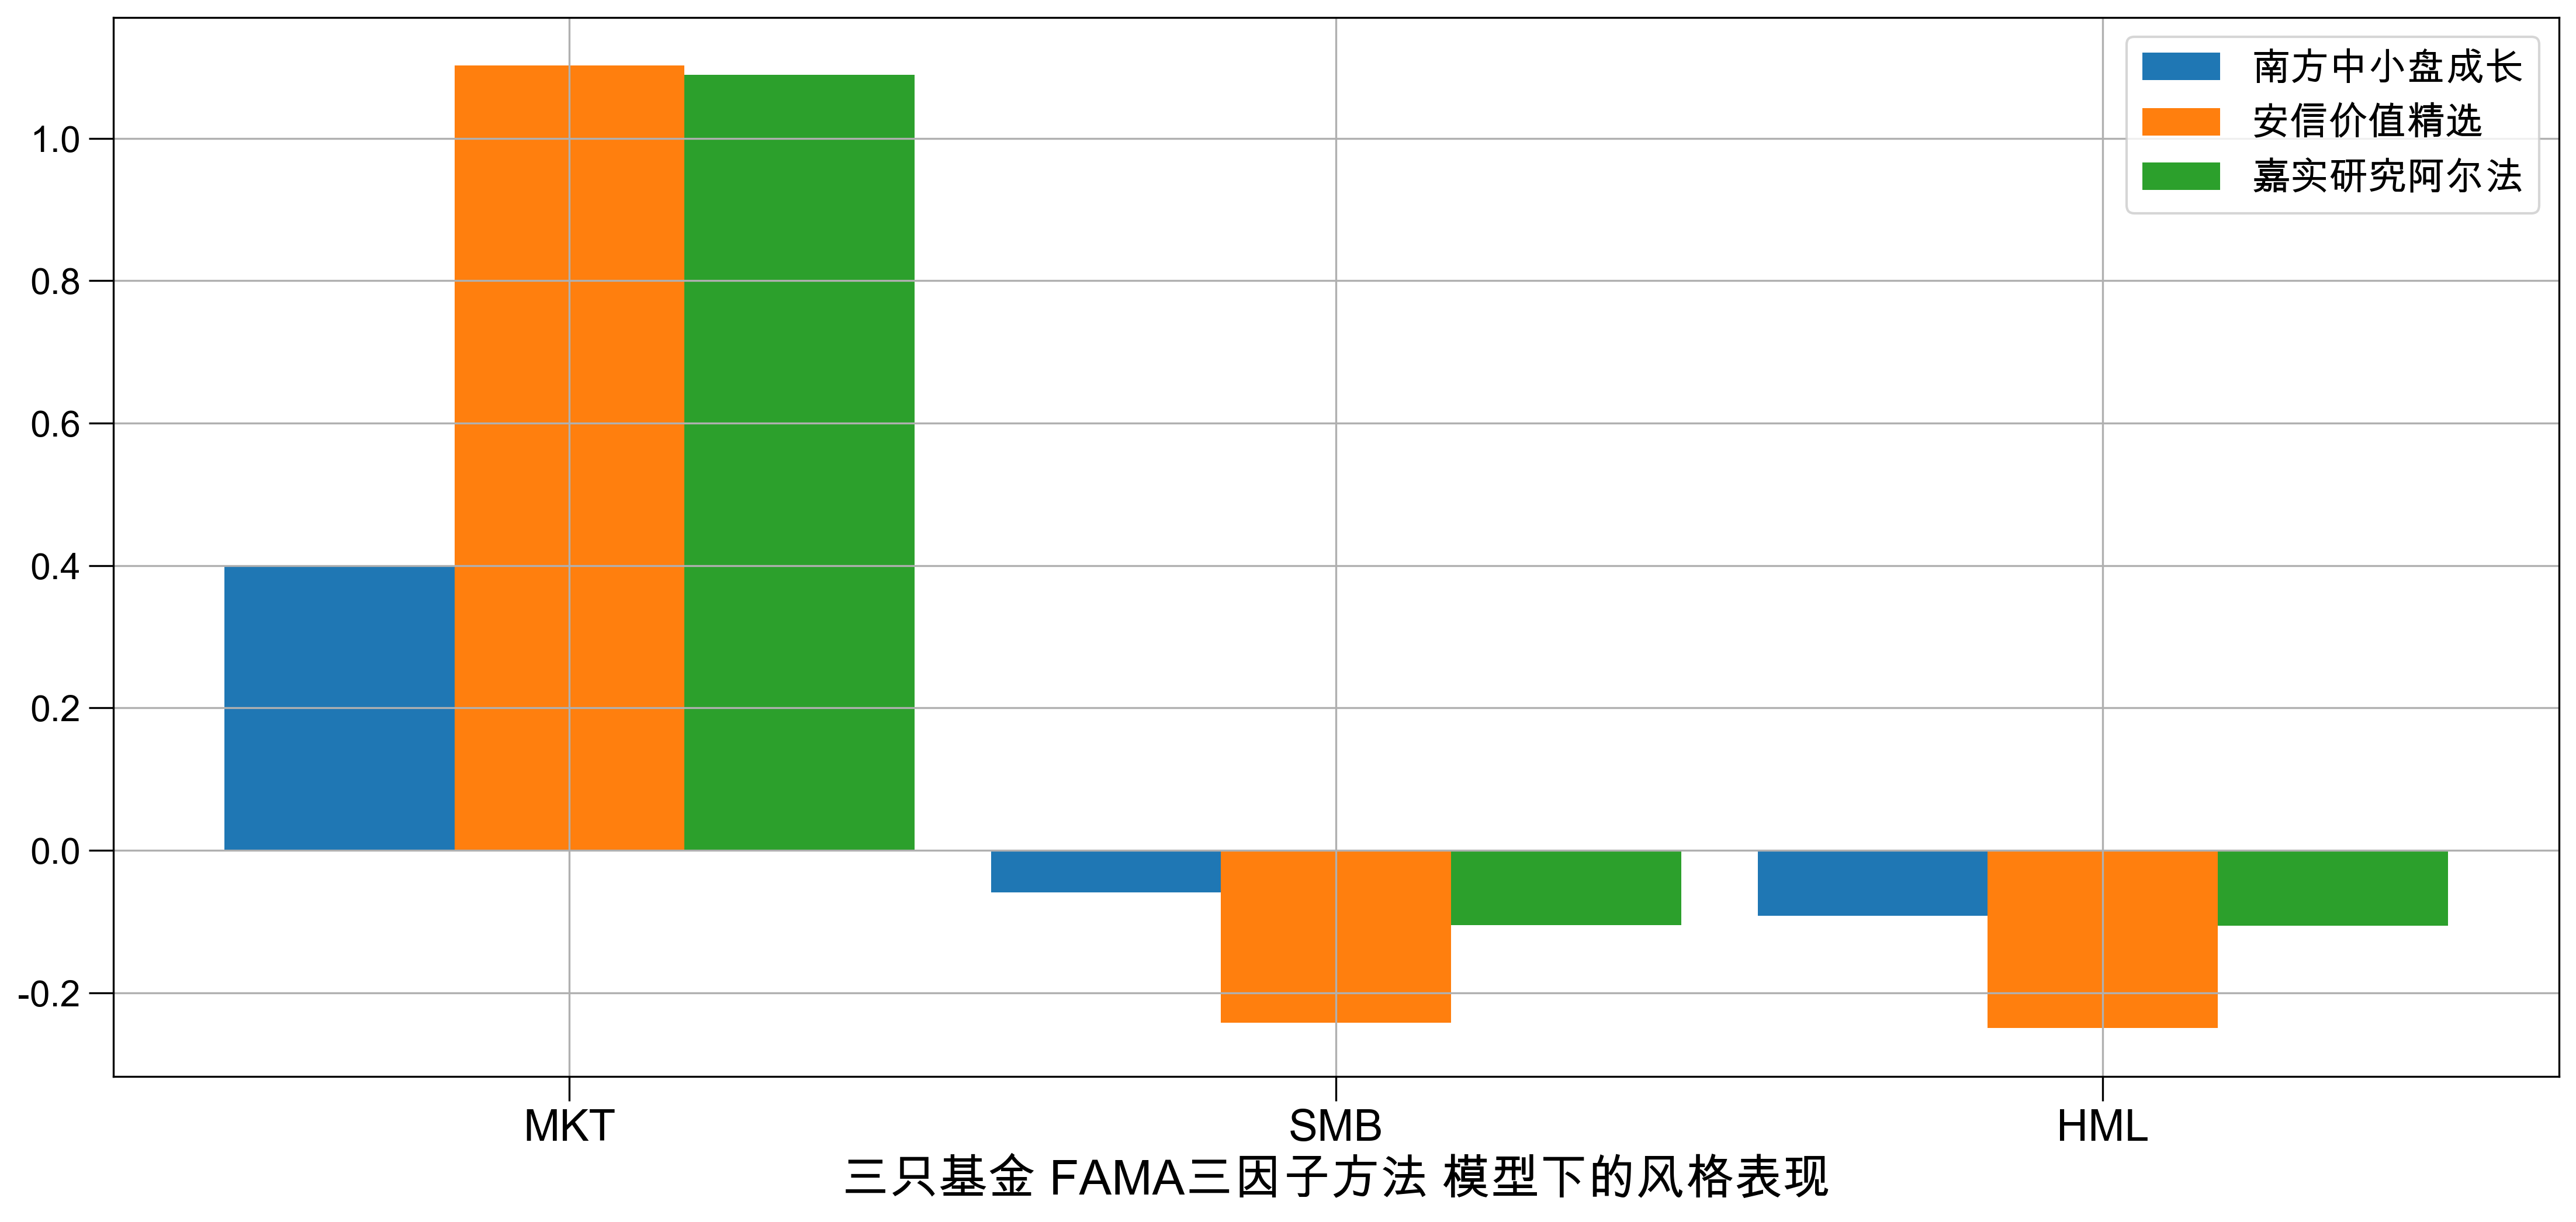

In [14]:
data_for_draw = output_total.T[['MKT','SMB','HML']].T.reset_index()
plt.bar(data_for_draw.index,data_for_draw['南方中小盘成长coef'],
        lw=0.5,width=0.3,label ='南方中小盘成长' )
plt.bar(data_for_draw.index+0.3,data_for_draw['安信价值精选coef'],
        lw=0.5,width=0.3,label ='安信价值精选' )
plt.bar(data_for_draw.index+0.6,data_for_draw['嘉实研究阿尔法coef'],
        lw=0.5,width=0.3,label = '嘉实研究阿尔法')

plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)

plt.legend(fontsize=16)
plt.grid()
plt.xlabel('三只基金 FAMA三因子方法 模型下的风格表现',fontsize=20)

plt.savefig('三只基金 FAMA三因子方法 模型下的风格表现.jpg')



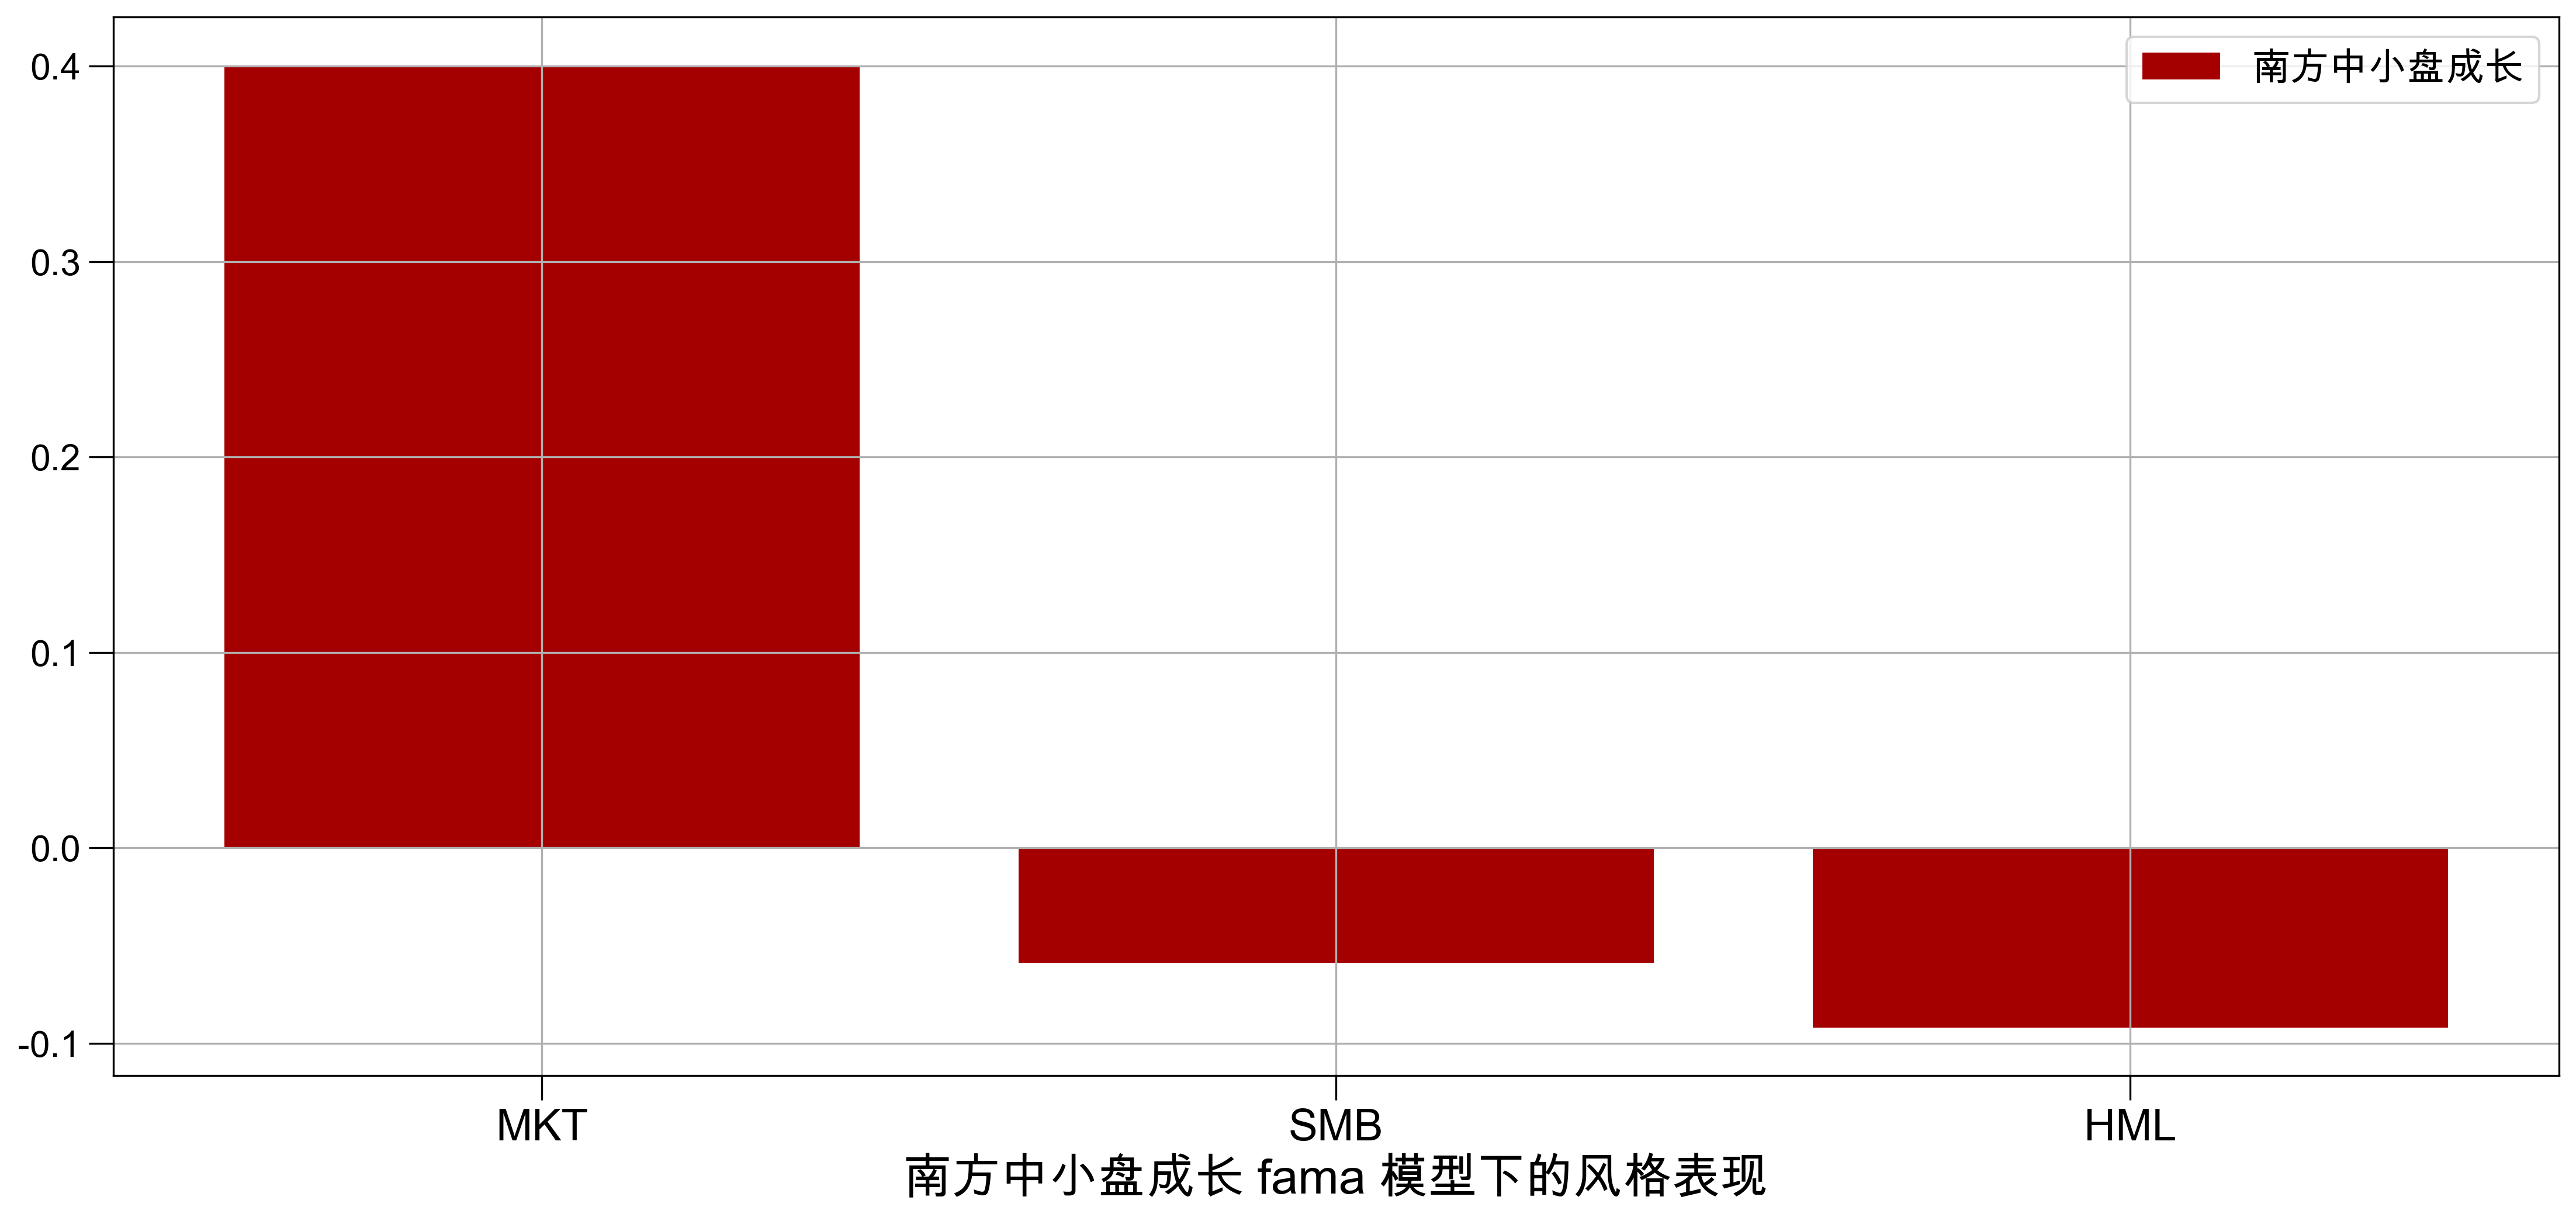

In [15]:
plt.bar(data_for_draw.index,data_for_draw['南方中小盘成长coef'],label ='南方中小盘成长',color = harvest_red )
plt.xticks(data_for_draw.index, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('南方中小盘成长 fama 模型下的风格表现',fontsize=20)
plt.savefig('南方中小盘成长 fama 模型下的风格表现.jpg')




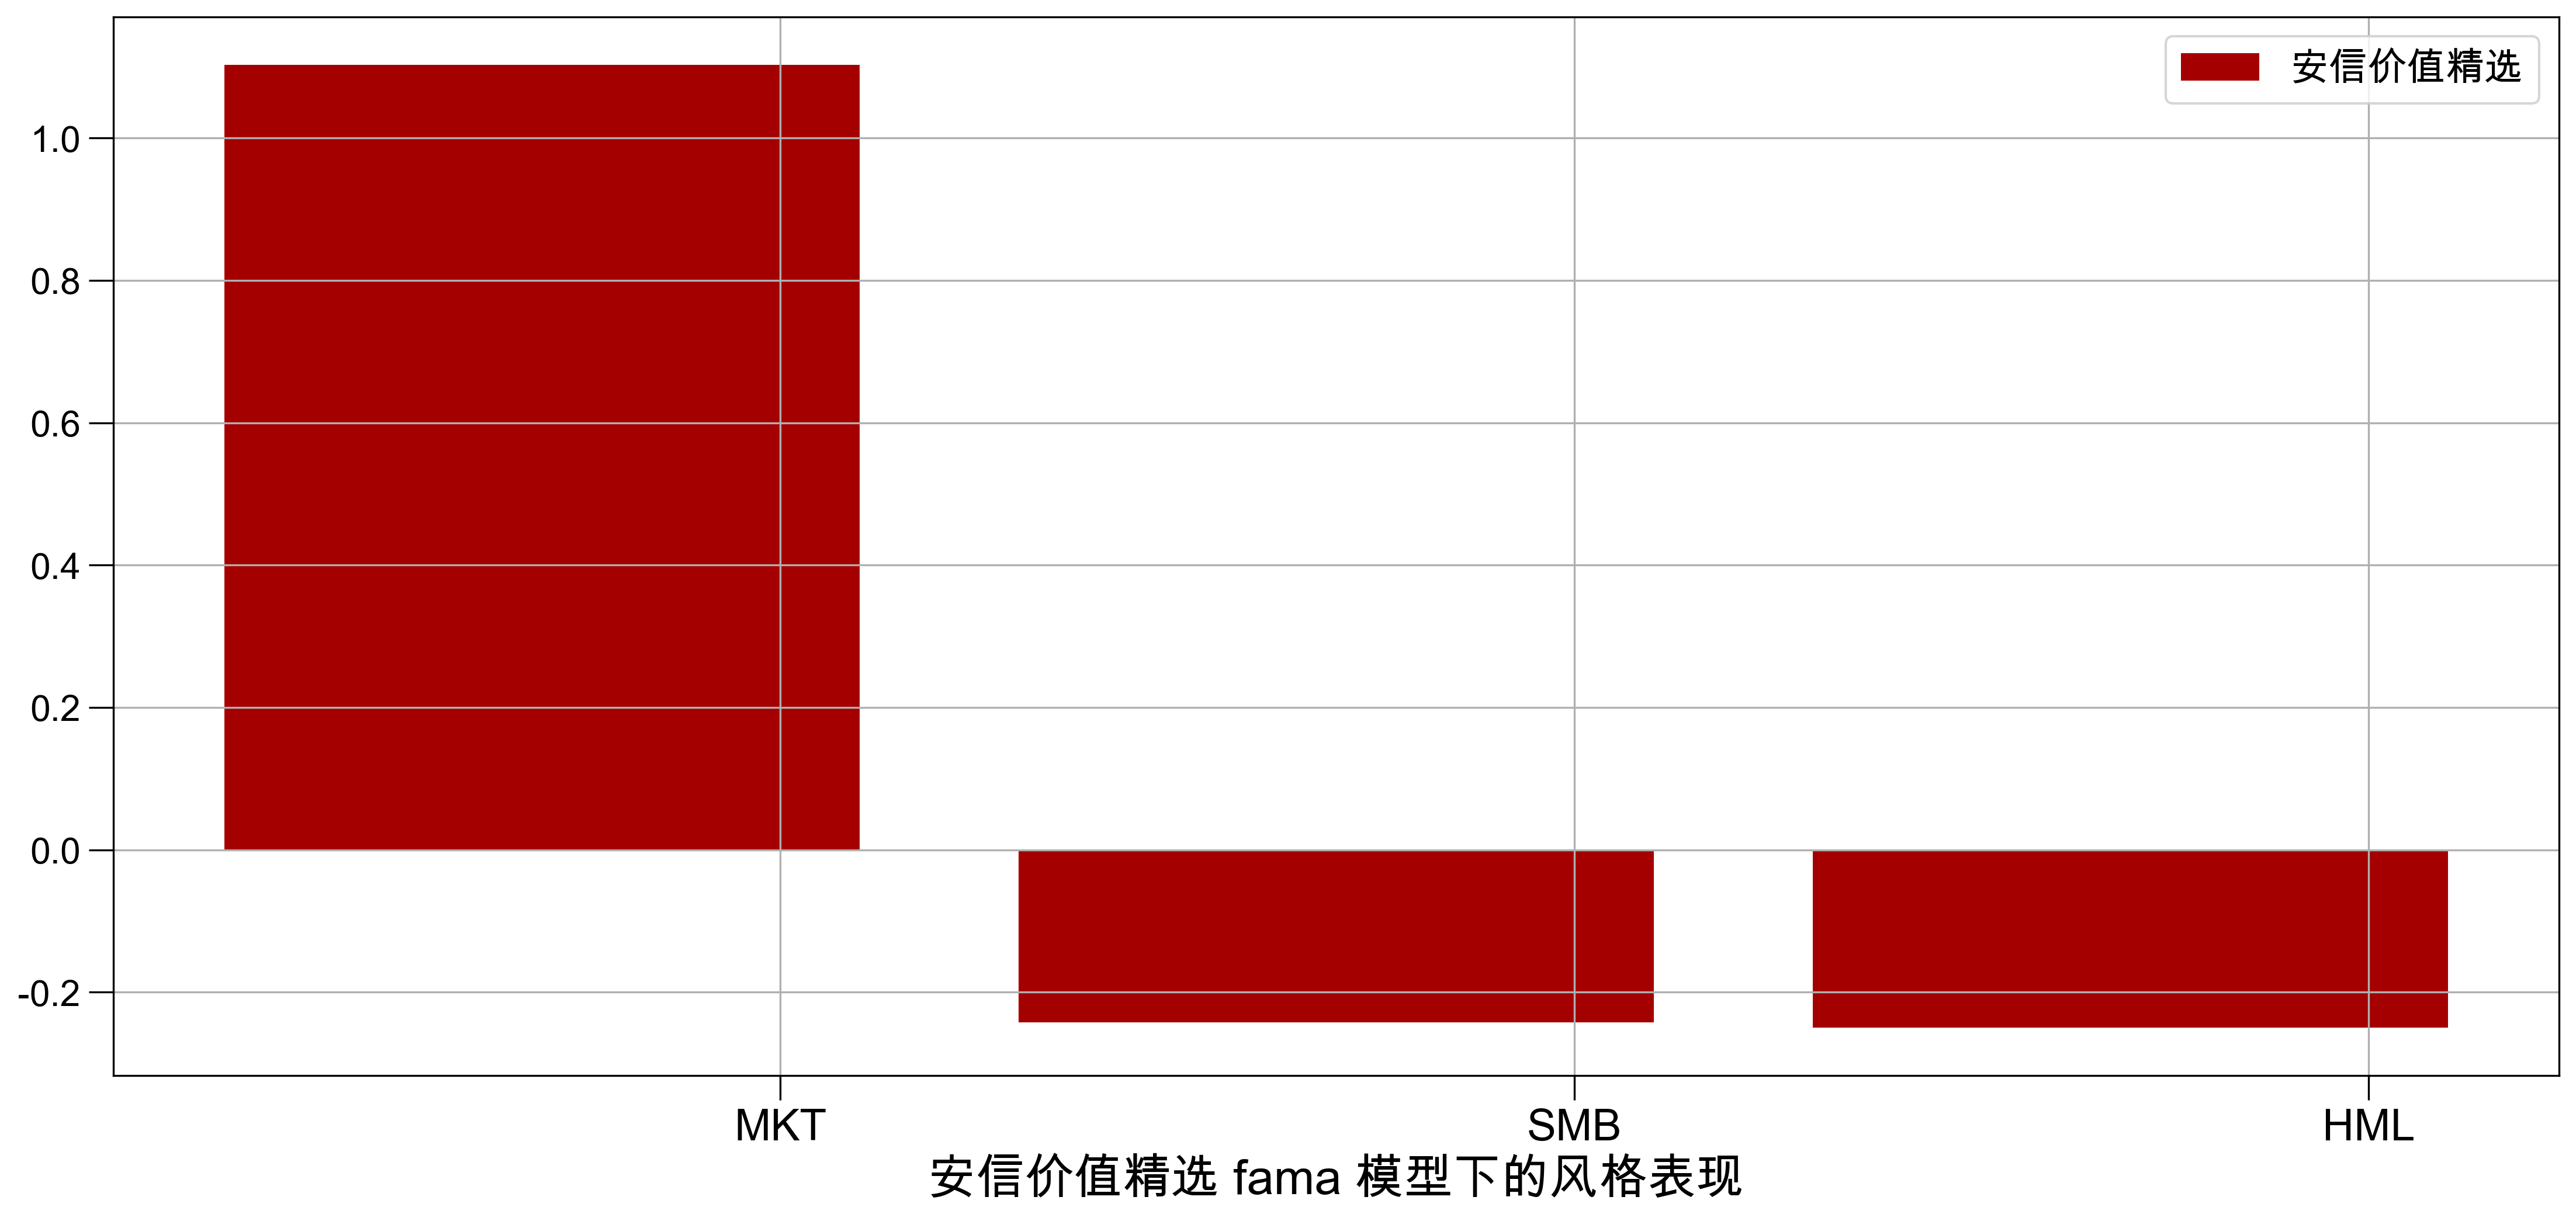

In [16]:
plt.bar(data_for_draw.index,data_for_draw['安信价值精选coef'],label ='安信价值精选' ,color = harvest_red)
plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('安信价值精选 fama 模型下的风格表现',fontsize=20)
plt.savefig('安信价值精选 fama 模型下的风格表现.jpg')



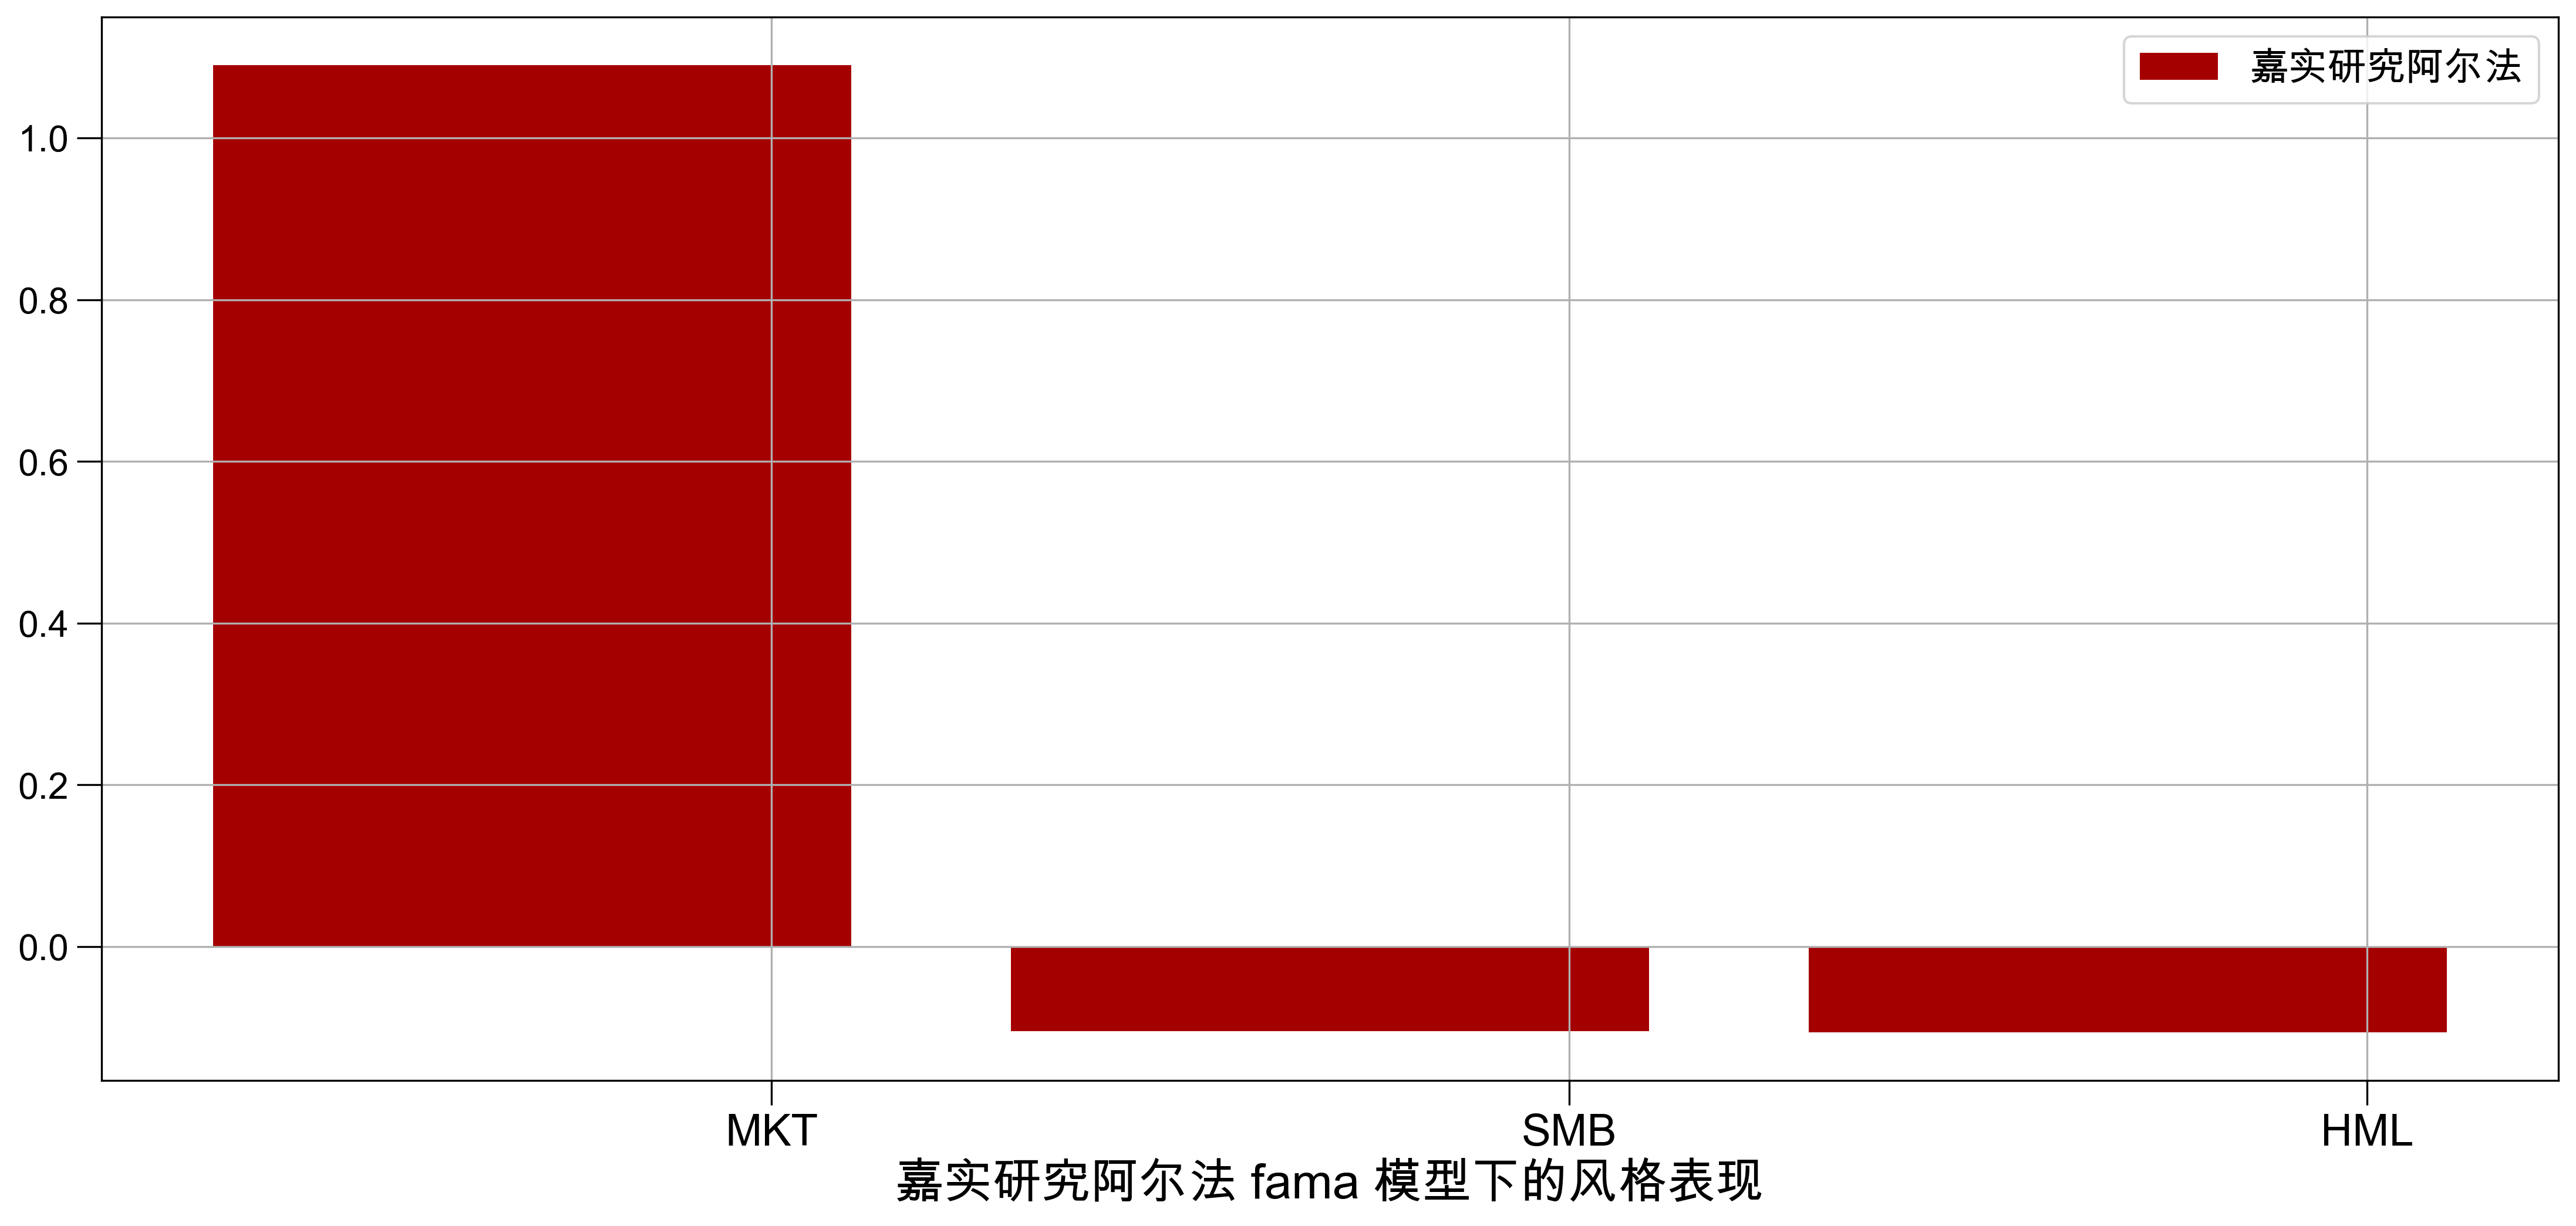

In [17]:
plt.bar(data_for_draw.index,data_for_draw['嘉实研究阿尔法coef'],label = '嘉实研究阿尔法',color = harvest_red)
plt.xticks(data_for_draw.index+0.3, list(data_for_draw['index'].values),fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('嘉实研究阿尔法 fama 模型下的风格表现',fontsize=20)
plt.savefig('嘉实研究阿尔法 fama 模型下的风格表现.jpg')



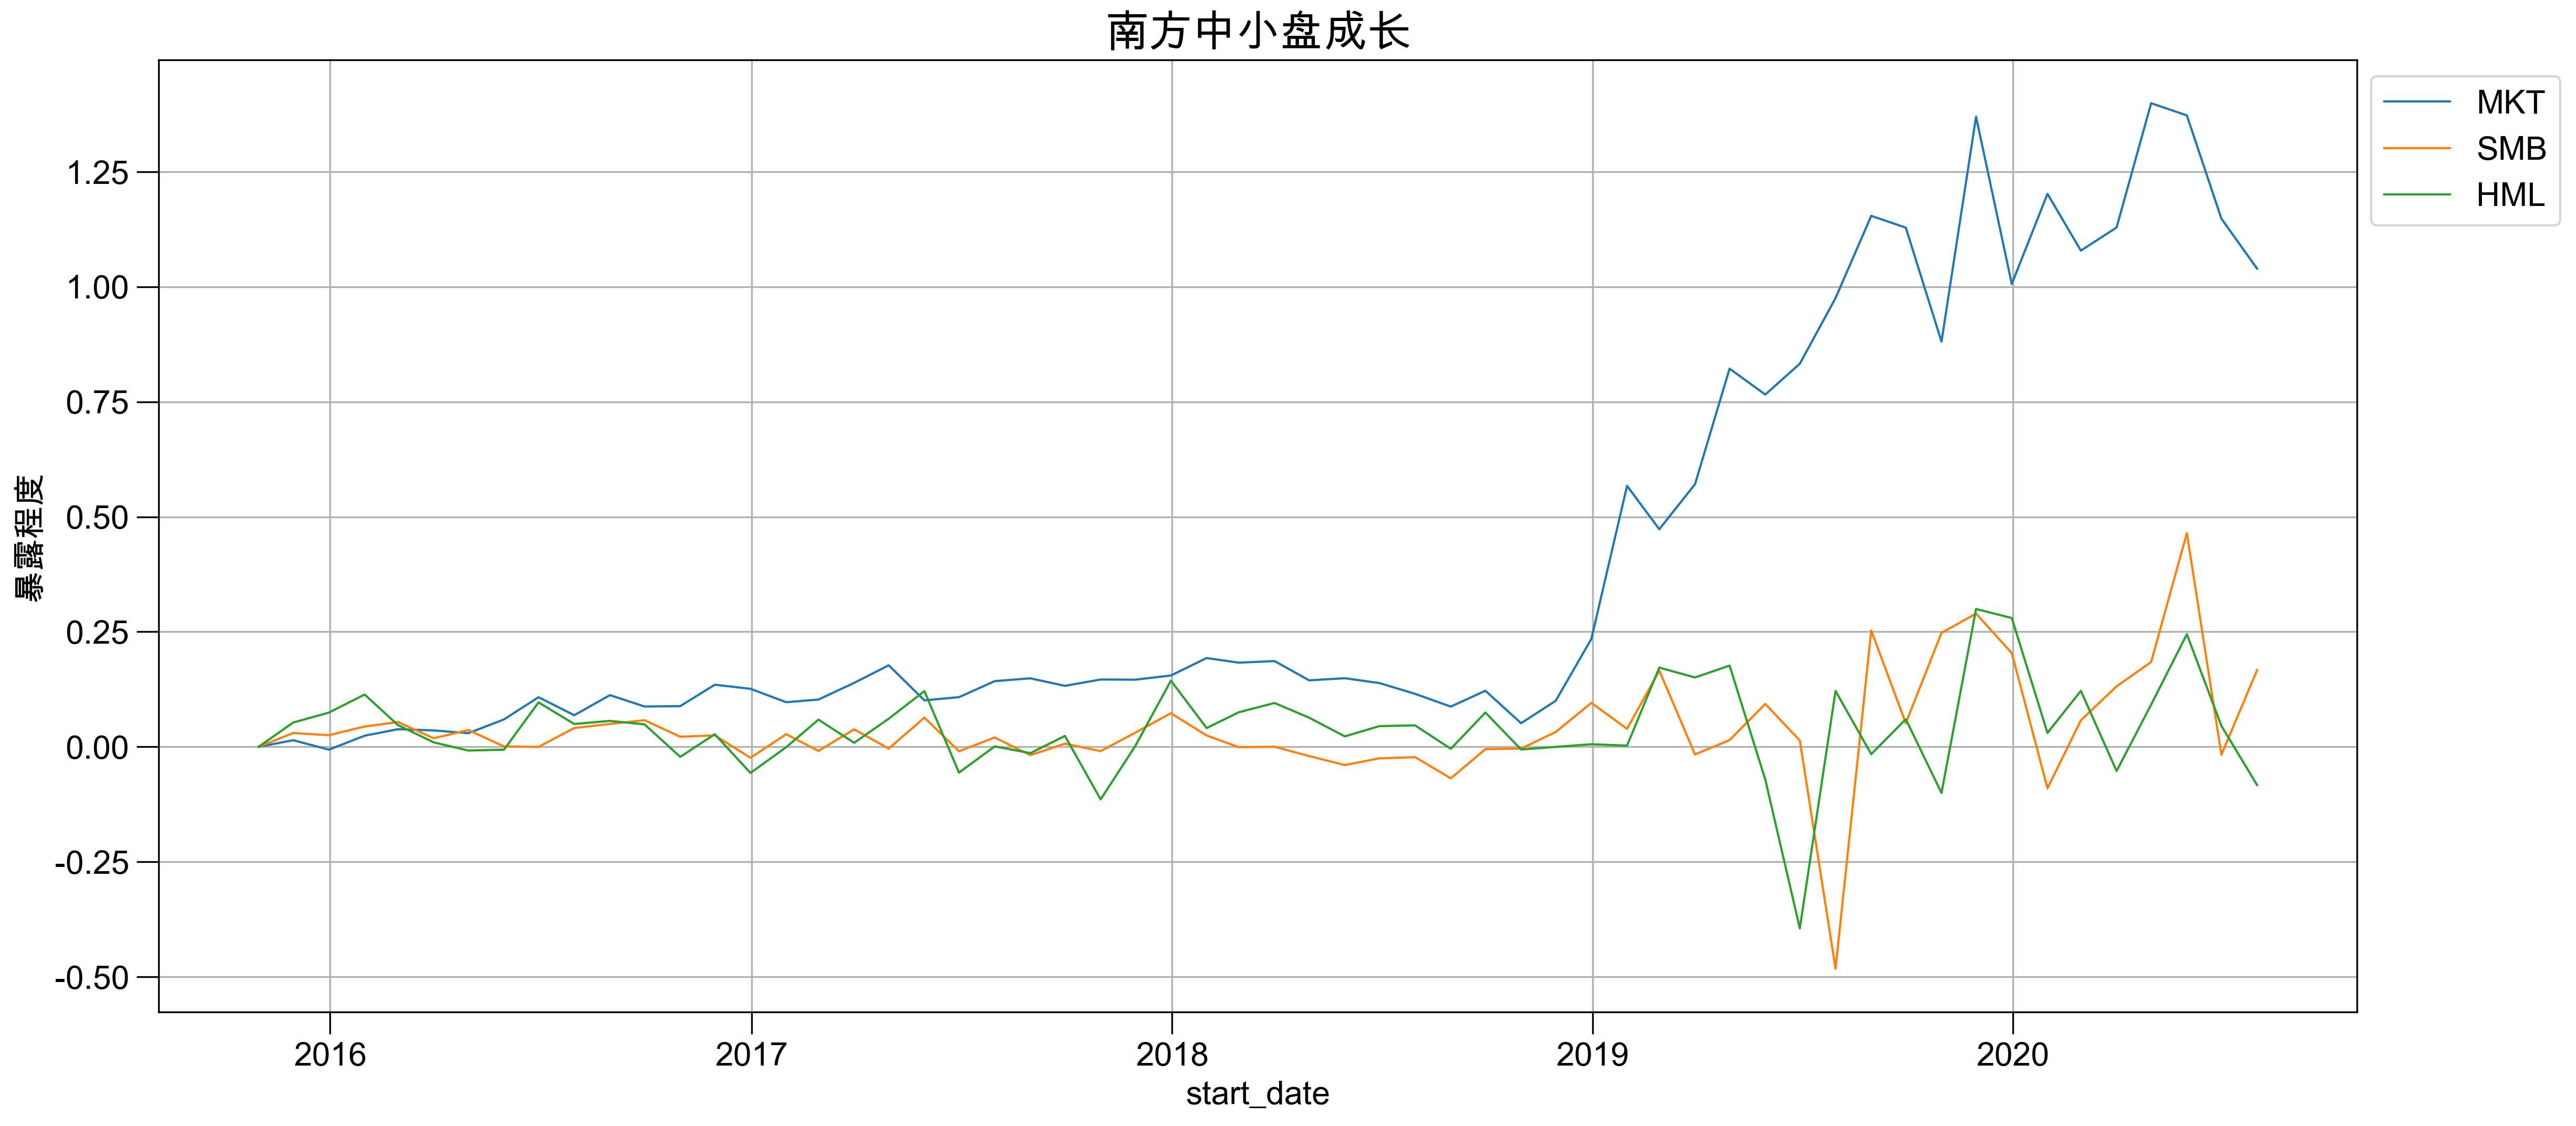

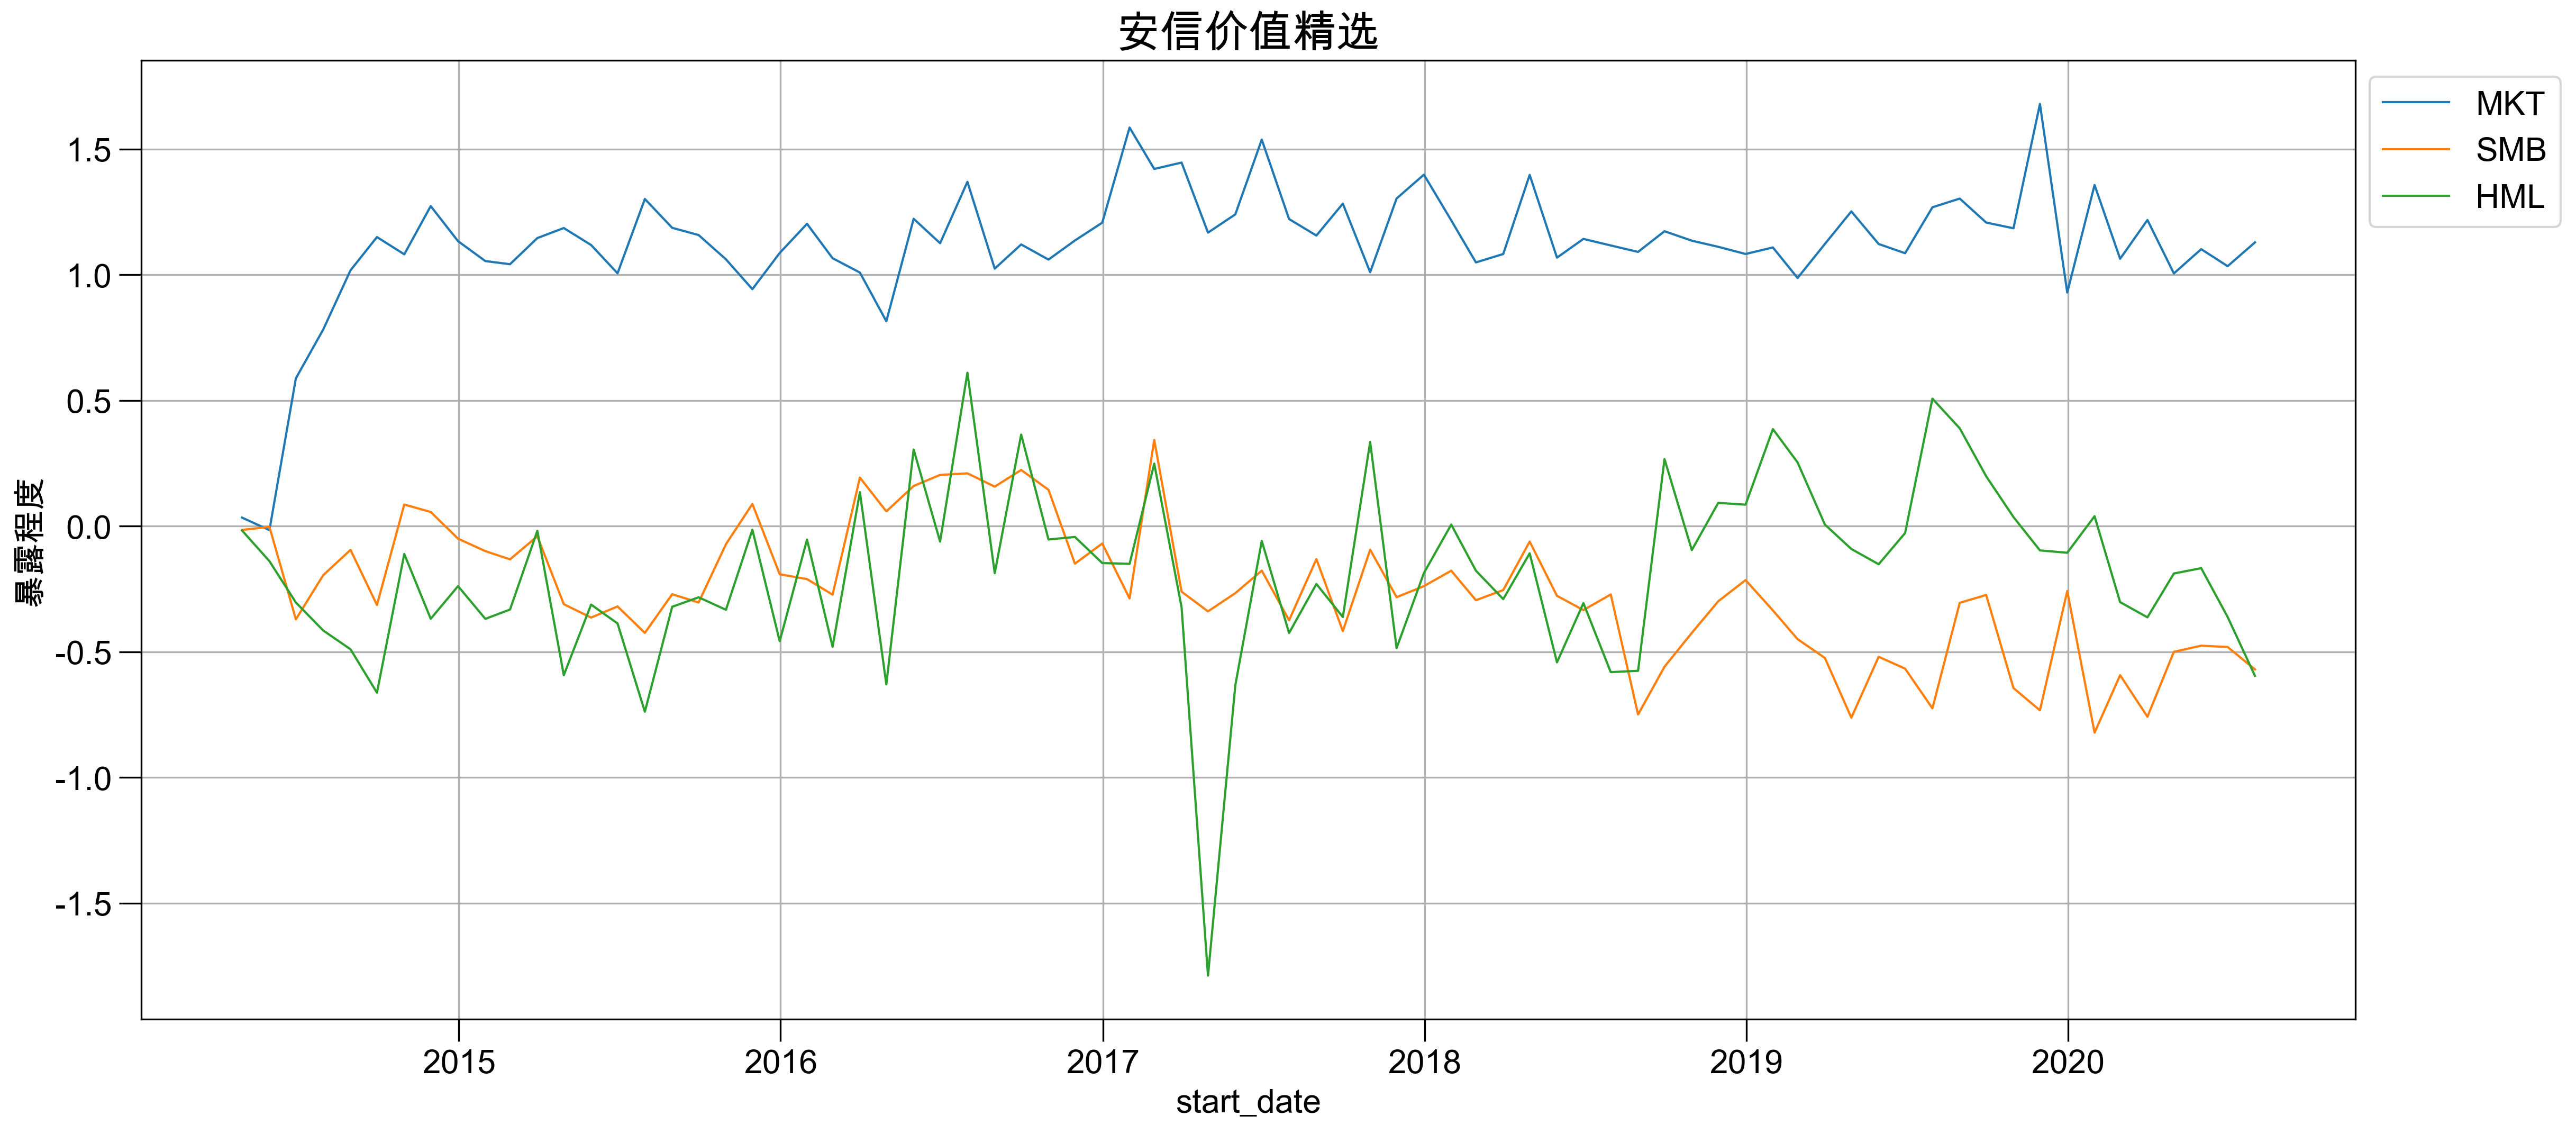

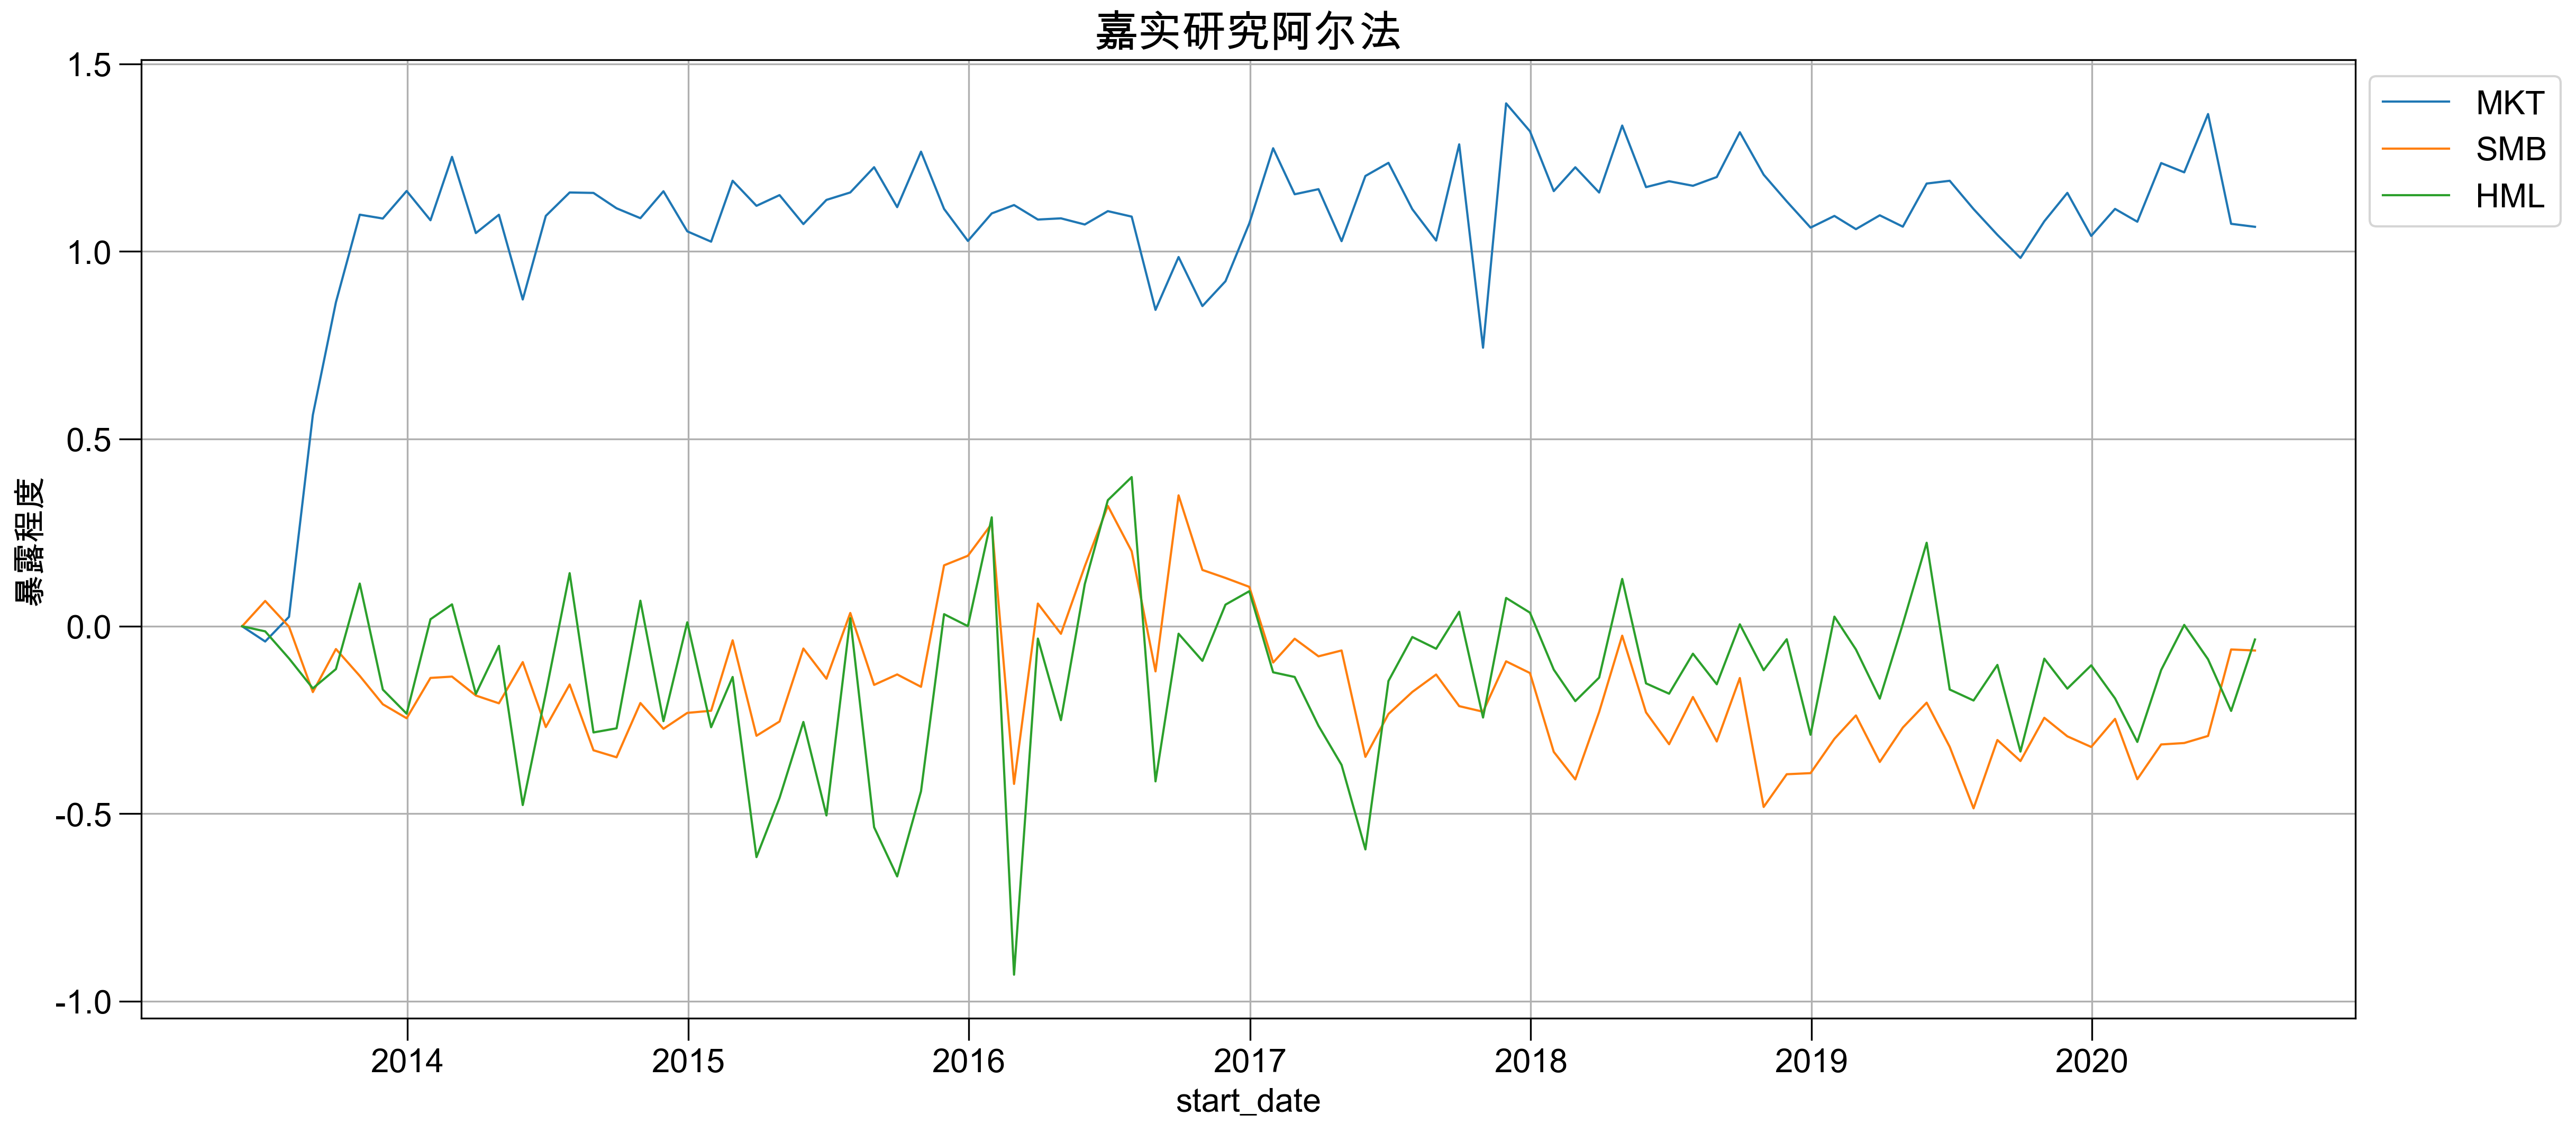

In [18]:
for j in range(len(name_list_for_fama)):
    data_1_for_draw = pd.read_excel(name_list_for_fama[j])
    data_1_for_draw = data_1_for_draw.rename(columns ={'Unnamed: 0':'日期'}).set_index('日期')
    plt.figure(figsize=(18,8))
    for i in data_1_for_draw.columns[1:]:
        plt.plot(data_1_for_draw[i].index,data_1_for_draw[i].values,
                 linestyle='-',  linewidth=1,label = i)

    plt.grid()
    plt.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
    plt.xlabel('start_date')
    plt.ylabel('暴露程度')
    plt.title(name_list_for_fama[j].split('roll')[0],fontsize=20)
    #plt.ylim(0,150)
    plt.savefig(name_list_for_fama[j].split('roll')[0]+'.jpg')